# **QBIO 465 Final Project: Predicting the Blood-Brain Barrier (BBB) Penetrability and LogBB of PET Tracers Using Neural Networks**
---
Erika Li, Tushar Zhade, Andrew Levy

Lecture: Tuesday and Thursday 12:30 PM-1:50 PM

5/14/25

In [1]:
# import necessary packages, libaries, and modules
import pandas as pd # for data manipulation
import numpy as np # for numerical operations
from rdkit import Chem # for molecule handling
from rdkit.Chem import Descriptors # for molecular descriptor calculation
from sklearn.model_selection import train_test_split # for splitting datasets
from sklearn.preprocessing import StandardScaler # for scaling feature values
from sklearn.pipeline import Pipeline # for chaining preprocessing and modeling
from sklearn.neural_network import MLPClassifier, MLPRegressor # for classification and regression models
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score # for evaluation metrics
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for additional visualization
import tensorflow as tf
from tensorflow.keras.models import Sequential # for building the model
from tensorflow.keras.layers import Dense, Dropout # for adding dense layers
from tensorflow.keras.optimizers import Adam # for model optimization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

**Load the B3DB Extended Classification Dataset**

In [2]:
# specify the path to the extended classification file
classification_extended_path_B3DB = 'data/B3DB_classification_extended.tsv.gz' # path to the extended classification file

# load the dataset using pandas, with tab separator and gzip compression
class_ext_df_B3DB = pd.read_csv(classification_extended_path_B3DB, sep='\t', compression='gzip') # read the extended classification dataset into a dataframe

# check the shape of the extended classification dataset
print('Shape of extended classification dataset:', class_ext_df_B3DB.shape) # print the shape (rows, columns)

# view the first few rows of the extended classification dataset
print(class_ext_df_B3DB.head()) # print the first five rows of the dataframe

Shape of extended classification dataset: (7807, 1625)
   NO.                        compound_name  \
0    1                       sulphasalazine   
1    2                           moxalactam   
2    3                           clioquinol   
3    4  bbcpd11 (cimetidine analog) (y-g13)   
4    5                        schembl614298   

                                          IUPAC_name  \
0  2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...   
1  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...   
2                       5-chloro-7-iodoquinolin-8-ol   
3  2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...   
4  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...   

                                              SMILES         CID  logBB  \
0   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      5339.0  -2.69   
1  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      3889.0  -2.52   
2                             Oc1c(I)cc(Cl)c2cccnc12      2788.0  -2.40   
3                        

/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/2682458019.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  class_ext_df_B3DB = pd.read_csv(classification_extended_path_B3DB, sep='\t', compression='gzip') # read the extended classification dataset into a dataframe


## **Descriptor-Based Classification Using a Fully Connected Neural Network (FCNN)**

**Select Features for BBB Classification**

In [3]:
# write the column names to a file in order to figure out what names to use when extracting the features
with open('columns_list_B3DB.txt', 'w') as f:
    for col in class_ext_df_B3DB.columns:
        f.write(col + '\n')

In [4]:
# define the list of selected descriptor columns
selected_features_B3DB = ['MW', 'TopoPSA', 'nHBDon', 'nHBAcc', 'SLogP', 'nRot', 'naRing'] # manually specify the relevant descriptor names based on dataset

# subset the feature set (X) using only the selected features
X_B3DB = class_ext_df_B3DB[selected_features_B3DB] # create the feature set by selecting the desired columns

# create the label set (y) from the 'BBB+/-' column
y_B3DB = class_ext_df_B3DB['BBB+/BBB-'] # select the 'BBB+/-' column as the target labels

# check the shapes of the resulting X and y
print('Shape of selected feature set (X_B3DB):', X_B3DB.shape) # print the shape of X
print('Shape of label set (y_B3DB):', y_B3DB.shape) # print the shape of y

# preview the first few rows of X
print(X_B3DB.head()) # print the first five rows of X

# preview the first few labels
print(y_B3DB.head()) # print the first five labels

Shape of selected feature set (X_B3DB): (7807, 7)
Shape of label set (y_B3DB): (7807,)
           MW  TopoPSA  nHBDon  nHBAcc    SLogP  nRot  naRing
0  398.068491   149.69       3       7  3.70160     6       3
1  520.101247   231.60       4      12 -1.12770     9       2
2  304.910439    33.12       1       2  3.19840     0       2
3  341.030979    98.40       2       4  2.11348     6       1
4  461.168581   149.15       5       9 -1.23650     3       1
0    BBB-
1    BBB-
2    BBB-
3    BBB-
4    BBB-
Name: BBB+/BBB-, dtype: object


**View Original Class Distribution**

In [5]:
# concatenate features and labels into one dataframe
df_B3DB = class_ext_df_B3DB[selected_features_B3DB + ['BBB+/BBB-']] # combine features and label

# print original class distribution
print('Original class distribution:')
print(df_B3DB['BBB+/BBB-'].value_counts())

Original class distribution:
BBB+/BBB-
BBB+    4956
BBB-    2851
Name: count, dtype: int64


As we can see, there is significant class imbalance here. There are about 2000 more BBB+ samples than BBB- samples. Therefore, we need to address this class imbalance. 

Initially, we planned to address class imbalance by supplementing the BBB− data with compounds from external sources. However, upon cross-referencing potential sources with the B3DB publication, we found that nearly all external datasets had already been integrated into B3DB. Including them again would introduce redundancy without adding new information. Given B3DB’s comprehensive coverage of publicly available BBB data, we will instead address the imbalance by randomly undersampling the overrepresented BBB+ class.

**Address Class Imbalance by Undersampling BBB+ Class**

In [6]:
# add SMILES to selected columns for GNN graph creation
selected_features_with_smiles = selected_features_B3DB + ['SMILES', 'BBB+/BBB-']

# create combined dataframe with features + SMILES + label
df_B3DB = class_ext_df_B3DB[selected_features_with_smiles]

# print original class distribution
print('Original class distribution:')
print(df_B3DB['BBB+/BBB-'].value_counts())

# split into BBB+ and BBB- subsets
df_BBBplus = df_B3DB[df_B3DB['BBB+/BBB-'] == 'BBB+'] # BBB+ samples
df_BBBminus = df_B3DB[df_B3DB['BBB+/BBB-'] == 'BBB-'] # BBB- samples

# randomly undersample the BBB+ class to match BBB- class
df_BBBplus_undersampled = df_BBBplus.sample(n=len(df_BBBminus), random_state=2025) # undersample

# concatenate and shuffle
df_balanced = pd.concat([df_BBBplus_undersampled, df_BBBminus], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=2025).reset_index(drop=True)

# split back into features and labels for FCNN
X_B3DB = df_balanced[selected_features_B3DB] # features only (no SMILES)
y_B3DB = df_balanced['BBB+/BBB-'] # target label

# confirm new class balance
print('Balanced class distribution:')
print(y_B3DB.value_counts())

Original class distribution:
BBB+/BBB-
BBB+    4956
BBB-    2851
Name: count, dtype: int64
Balanced class distribution:
BBB+/BBB-
BBB+    2851
BBB-    2851
Name: count, dtype: int64


**Split into Training and Validation Sets, and Scale Features**

In [7]:
# split the dataset into training and validation subsets (80% train, 20% validation)
X_train_B3DB, X_val_B3DB, y_train_B3DB, y_val_B3DB = train_test_split(X_B3DB, y_B3DB, test_size=0.2, random_state=2025, stratify=y_B3DB) # use stratify to maintain class balance

# initialize the scaler
scaler_B3DB = StandardScaler() # initialize the standard scaler to normalize feature values

# fit the scaler on the training features
scaler_B3DB.fit(X_train_B3DB) # fit only on training data to avoid information leak

# transform both training and validation features
X_train_scaled_B3DB = pd.DataFrame(scaler_B3DB.transform(X_train_B3DB), columns=X_train_B3DB.columns, index=X_train_B3DB.index) # transform and wrap back into a DataFrame
X_val_scaled_B3DB = pd.DataFrame(scaler_B3DB.transform(X_val_B3DB), columns=X_val_B3DB.columns, index=X_val_B3DB.index) # transform and wrap validation set

# check the shapes of the scaled feature sets
print('Shape of scaled training feature set (X_train_scaled_B3DB):', X_train_scaled_B3DB.shape) # print shape
print('Shape of scaled validation feature set (X_val_scaled_B3DB):', X_val_scaled_B3DB.shape) # print s

Shape of scaled training feature set (X_train_scaled_B3DB): (4561, 7)
Shape of scaled validation feature set (X_val_scaled_B3DB): (1141, 7)


In [8]:
# check class distribution in original labels
print('Original class distribution:')
print(y_B3DB.value_counts())

# check class distribution in training labels
print('Training class distribution:')
print(y_train_B3DB.value_counts())

# check class distribution in validation labels
print('Validation class distribution:')
print(y_val_B3DB.value_counts())

Original class distribution:
BBB+/BBB-
BBB+    2851
BBB-    2851
Name: count, dtype: int64
Training class distribution:
BBB+/BBB-
BBB-    2281
BBB+    2280
Name: count, dtype: int64
Validation class distribution:
BBB+/BBB-
BBB+    571
BBB-    570
Name: count, dtype: int64


**Train a Basic MLP using the Sequential API**

In [9]:
# initialize the Sequential model
model_FCNN = Sequential()

# first hidden layer
model_FCNN.add(Dense(64, activation='relu', input_shape=(X_train_scaled_B3DB.shape[1],))) # first dense layer with 64 units and relu activation
model_FCNN.add(Dropout(0.3)) # add 30% dropout

# second hidden layer
model_FCNN.add(Dense(32, activation='relu')) # second dense layer with 32 units and relu activation

# output layer
model_FCNN.add(Dense(1, activation='sigmoid')) # output layer for binary classification with sigmoid activation

# compile the model
model_FCNN.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) # use Adam optimizer, binary crossentropy loss, and track accuracy

/Users/andrewlevy/anaconda3/envs/QBIO465_final_project/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# print model summary
print('Sequential MLP model summary:')
model_FCNN.summary()

Sequential MLP model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train the Model**

In [11]:
# train the model on the training data
history_FCNN = model_FCNN.fit(X_train_scaled_B3DB, y_train_B3DB.replace({'BBB-': 0, 'BBB+': 1}),
                              validation_data=(X_val_scaled_B3DB, y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1})),
                              epochs=100, batch_size=32, verbose=1) # train for 100 epochs, batch size of 32

Epoch 1/100


/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/2510188809.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  history_FCNN = model_FCNN.fit(X_train_scaled_B3DB, y_train_B3DB.replace({'BBB-': 0, 'BBB+': 1}),
/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/2510188809.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_data=(X_val_scaled_B3DB, y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1})),


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7295 - loss: 0.5640 - val_accuracy: 0.7879 - val_loss: 0.4821
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.7680 - loss: 0.4986 - val_accuracy: 0.7862 - val_loss: 0.4681
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.7857 - loss: 0.4731 - val_accuracy: 0.7897 - val_loss: 0.4588
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7777 - loss: 0.4829 - val_accuracy: 0.7870 - val_loss: 0.4503
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.4632 - val_accuracy: 0.7932 - val_loss: 0.4456
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7800 - loss: 0.4643 - val_accuracy: 0.7905 - val_loss: 0.4392
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7895 - loss: 0.4569 - val_accuracy: 0.7958 - val_loss: 0.4382
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7792 - loss: 0.4651 - val_accu

**Plot Training and Validation Accuracy and Loss Curves**

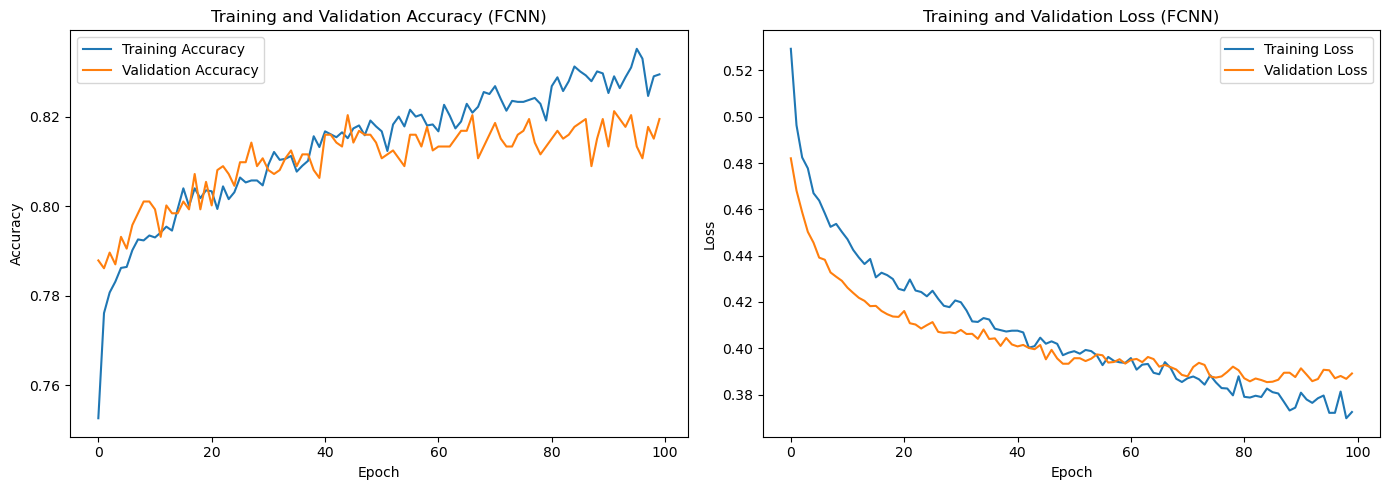

In [13]:
# create a figure with two subplots (side-by-side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) # one row, two columns

# plot accuracy
ax1.plot(history_FCNN.history['accuracy'], label='Training Accuracy') # plot training accuracy
ax1.plot(history_FCNN.history['val_accuracy'], label='Validation Accuracy') # plot validation accuracy
ax1.set_title('Training and Validation Accuracy (FCNN)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# plot loss
ax2.plot(history_FCNN.history['loss'], label='Training Loss') # plot training loss
ax2.plot(history_FCNN.history['val_loss'], label='Validation Loss') # plot validation loss
ax2.set_title('Training and Validation Loss (FCNN)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

**Analysis**

In the accuracy plot (left), both the training and validation accuracies increase steadily during the first 30 epochs and then begin to plateau around ~81–83%. While the training accuracy continues to improve slightly throughout training, the validation accuracy stabilizes, exhibiting minor fluctuations without a clear upward or downward trend. The fact that validation accuracy remains close to training accuracy—with no significant gap—suggests that the model is not overfitting and is generalizing reasonably well to unseen data.

In the loss plot (right), both the training and validation losses decrease sharply during the initial 20–30 epochs before leveling off. The training loss continues to decline gradually across the full 100 epochs, while the validation loss exhibits a flatter curve with occasional small increases. Although the validation loss remains consistently higher than the training loss, the gap between the two is narrow and stable, which is generally a good sign. The model appears to be learning without overfitting, and the dropout layer may be contributing to this regularization.

Overall, the training curves indicate a healthy learning trajectory, with improvements tapering off but no signs of divergence. These results suggest that the model has reached a performance plateau around epoch 80–100, and while extending training might yield slight gains, the current model is already performing robustly. The balance between training and validation performance demonstrates that the model is extracting meaningful patterns from the descriptors while maintaining generalization.

**Generate and Plot Confusion Matrix**

In [14]:
# predict labels on the validation set
y_val_pred_probs_FCNN = model_FCNN.predict(X_val_scaled_B3DB).flatten() # predict probabilities
y_val_pred_labels_FCNN = (y_val_pred_probs_FCNN > 0.5).astype(int) # convert probabilities to class labels (threshold at 0.5)

# true labels for comparison (convert to 0/1)
y_val_true_FCNN = y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1}) # replace BBB labels with binary 0/1

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step


/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/2865827490.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val_true_FCNN = y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1}) # replace BBB labels with binary 0/1


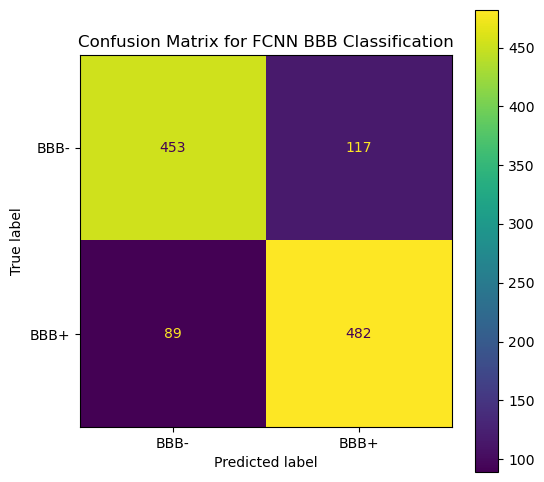

In [15]:
# create the confusion matrix
conf_matrix_FCNN = confusion_matrix(y_val_true_FCNN, y_val_pred_labels_FCNN) # compute confusion matrix

# create a display object
cm_disp_FCNN = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_FCNN, display_labels=['BBB-', 'BBB+'])

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6)) # set figure size
cm_disp_FCNN.plot(ax=ax) # plot confusion matrix on specified axes
ax.set(title='Confusion Matrix for FCNN BBB Classification') # add title
plt.show() # show the plot

**Plot ROC Curve and Calculate AUC Score**

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/2710263909.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val_true_FCNN = y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1}) # convert BBB labels to binary 0/1


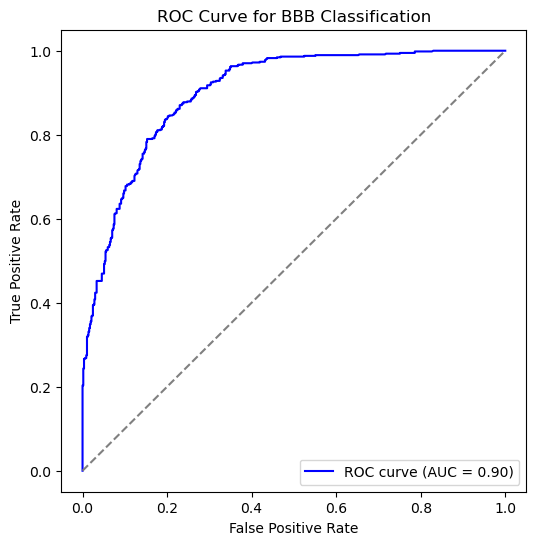

Validation AUC Score: 0.9021123298614311


In [16]:
# compute predicted probabilities for validation set
y_val_pred_probs_FCNN = model_FCNN.predict(X_val_scaled_B3DB).flatten() # get predicted probabilities

# true labels for validation set
y_val_true_FCNN = y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1}) # convert BBB labels to binary 0/1

# calculate the ROC curve points
fpr_FCNN, tpr_FCNN, thresholds_FCNN = roc_curve(y_val_true_FCNN, y_val_pred_probs_FCNN) # false positive rate, true positive rate

# calculate the area under the curve (AUC)
roc_auc_FCNN = auc(fpr_FCNN, tpr_FCNN) # compute AUC score

# plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6)) # set figure size
ax.plot(fpr_FCNN, tpr_FCNN, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc_FCNN)) # plot ROC curve
ax.plot([0, 1], [0, 1], color='gray', linestyle='--') # plot diagonal line for random guess
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve for BBB Classification') # set labels and title
ax.legend(loc='lower right') # place legend in lower right
plt.show() # display the plot

# print the final AUC value
print('Validation AUC Score:', roc_auc_FCNN) # print the AUC score

**Generate and Print Classification Report**

In [17]:
# generate predicted class labels (threshold at 0.5)
y_val_pred_labels_FCNN = (model_FCNN.predict(X_val_scaled_B3DB) > 0.5).astype(int).flatten() # convert probabilities to binary class predictions

# true binary labels
y_val_true_FCNN = y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1}) # convert actual labels to 0/1

# generate the classification report
report_FCNN = classification_report(y_val_true_FCNN, y_val_pred_labels_FCNN, target_names=['BBB-', 'BBB+']) # use class names for readability

# print the classification report
print('Classification Report:\n', report_FCNN)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
Classification Report:
               precision    recall  f1-score   support

        BBB-       0.84      0.79      0.81       570
        BBB+       0.80      0.84      0.82       571

    accuracy                           0.82      1141
   macro avg       0.82      0.82      0.82      1141
weighted avg       0.82      0.82      0.82      1141



/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/466179430.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val_true_FCNN = y_val_B3DB.replace({'BBB-': 0, 'BBB+': 1}) # convert actual labels to 0/1


**Analysis**

The fully connected neural network (FCNN) model demonstrates strong and balanced performance in predicting blood-brain barrier (BBB) permeability, as evidenced by the validation confusion matrix, ROC curve, AUC score, and classification report. From the confusion matrix, the model correctly identifies 453 of 570 BBB− compounds and 482 of 571 BBB+ compounds, with a relatively even distribution of misclassifications (117 false positives and 89 false negatives). This balance suggests that the model does not disproportionately favor one class over the other. This is a key outcome given that class imbalance was addressed earlier through undersampling.

The classification report further reinforces this interpretation, with precision, recall, and F1-scores all hovering around 0.80–0.84 for both classes. Notably, the macro and weighted averages are both 0.82, indicating consistent performance across the dataset without class bias. Additionally, the model achieves a validation AUC of 0.90, as shown in the ROC curve, which reflects excellent discriminatory capacity. The steep rise of the ROC curve and its deviation from the diagonal suggest that the model is highly effective at separating BBB+ from BBB− molecules across different decision thresholds.

Taken together, these metrics indicate that the FCNN model has learned meaningful, generalizable patterns from the descriptor-based feature set. 

## **Graph-Based Classification Using a Graph Neural Network (GNN)**

In [18]:
import torch
import torch_geometric

In [19]:
from torch_geometric.data import Data

**Convert SMILES to PyG Graphs**

In [20]:
from tqdm import tqdm

In [21]:
# define function to convert RDKit Mol object to a PyTorch Geometric Data object
def mol_to_pyg_data_B3DB(mol, label):
    """Convert an RDKit molecule to a PyTorch Geometric Data object with enhanced atom and bond features."""
    
    atom_features = [] # list to store features for each atom
    edge_index = []    # list to store edges between atoms
    edge_features = [] # list to store bond features for each edge

    # loop through atoms and collect atom-level features
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),                              # atomic number
            int(atom.GetIsAromatic()),                        # is aromatic (boolean)
            int(atom.GetHybridization()),                     # hybridization type (enum int)
            atom.GetFormalCharge(),                           # formal charge
            atom.GetNumImplicitHs(),                          # number of implicit hydrogens
            int(atom.GetBoolProp('is_hbd') if atom.HasProp('is_hbd') else 0), # hydrogen bond donor
            int(atom.GetBoolProp('is_hba') if atom.HasProp('is_hba') else 0)  # hydrogen bond acceptor
        ]
        atom_features.append(features) # append the atom's features to the full list

    # loop through bonds and collect bond-level features
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx() # index of starting atom
        end = bond.GetEndAtomIdx()     # index of ending atom

        # construct edge in both directions (undirected graph)
        edge_index.append([start, end])
        edge_index.append([end, start])

        # extract bond features (same for both directions)
        bond_features = [
            int(bond.GetBondTypeAsDouble()),  # bond type (1=single, 2=double, etc.)
            int(bond.GetIsConjugated()),      # is conjugated
            int(bond.IsInRing()),             # is in a ring
            int(bond.GetStereo()),            # stereochemistry (enum)
            int(bond.GetBondDir()),           # bond direction (enum)
            int(bond.GetIsAromatic())         # is aromatic
        ]
        edge_features.append(bond_features) # append forward edge features
        edge_features.append(bond_features) # append reverse edge features

    # convert lists to tensors
    x = torch.tensor(atom_features, dtype=torch.float)                         # node features
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # edges
    edge_attr = torch.tensor(edge_features, dtype=torch.float)                # edge features

    # create the Data object with node, edge, and label information
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([label], dtype=torch.float))

    return data

In [22]:
# initialize list to store graph Data objects
data_list_B3DB = []

# loop through the SMILES strings and create graphs
for i, row in tqdm(df_balanced.iterrows(), total=len(df_balanced)):
    smiles = row['SMILES']
    label_str = row['BBB+/BBB-']
    label = 1 if label_str == 'BBB+' else 0

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        continue # skip invalid SMILES

    data = mol_to_pyg_data_B3DB(mol, label)
    data_list_B3DB.append(data)

# print how many molecules successfully converted
print('Number of Molecule Graphs Created:', len(data_list_B3DB))

[13:28:11] Explicit valence for atom # 10 C, 4, is greater than permitted                                      | 2954/5702 [00:01<00:01, 2557.35it/s]
[13:28:11] Explicit valence for atom # 10 C, 4, is greater than permitted
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5702/5702 [00:02<00:00, 2553.75it/s]

Number of Molecule Graphs Created: 5700


**Create Dataset and Split into Train/Validation Sets**

In [23]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

In [24]:
# create a simple custom InMemoryDataset
class MoleculeDataset_B3DB(InMemoryDataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [25]:
# wrap data_list into MoleculeDataset
full_dataset_B3DB = MoleculeDataset_B3DB(data_list_B3DB)

In [26]:
# split into train and validation sets (80% train, 20% val)
train_idx_B3DB, val_idx_B3DB = train_test_split(range(len(full_dataset_B3DB)), test_size=0.2, random_state=2025, stratify=[data.y.item() for data in full_dataset_B3DB])

train_dataset_B3DB = torch.utils.data.Subset(full_dataset_B3DB, train_idx_B3DB)
val_dataset_B3DB = torch.utils.data.Subset(full_dataset_B3DB, val_idx_B3DB)

In [27]:
# create DataLoaders
train_loader_B3DB = DataLoader(train_dataset_B3DB, batch_size=32, shuffle=True)
val_loader_B3DB = DataLoader(val_dataset_B3DB, batch_size=32, shuffle=False)

In [28]:
# check
print('Training samples:', len(train_dataset_B3DB))
print('Validation samples:', len(val_dataset_B3DB))

Training samples: 4560
Validation samples: 1140


**Define the GNN Model (With Rich Atom and Bond Features)**

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.nn.models import MLP

In [30]:
class GNN_B3DB(nn.Module):
    def __init__(self):
        super(GNN_B3DB, self).__init__()

        # define the first MLP used by the first GINEConv layer
        mlp1 = MLP([7, 64], norm=None)  # atom features dim = 7 → output = 64

        # define the second MLP used by the second GINEConv layer
        mlp2 = MLP([64, 32], norm=None)  # 64 → 32

        # updated: specify edge_dim=6 because bond features have dimension 6
        self.conv1 = GINEConv(nn=mlp1, edge_dim=6)  # GINEConv layer 1
        self.conv2 = GINEConv(nn=mlp2, edge_dim=6)  # GINEConv layer 2

        # dense layers
        self.fc1 = nn.Linear(32, 16)  # graph-level layer
        self.fc2 = nn.Linear(16, 1)   # output layer for binary classification

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return torch.sigmoid(x).view(-1)

**Train the GNN Model**

In [31]:
# initialize the GNN model
model_GNN_B3DB = GNN_B3DB()

# choose device: GPU if available, else CPU
device_GNN_B3DB = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GNN_B3DB = model_GNN_B3DB.to(device_GNN_B3DB) # move model to device

# define loss function and optimizer
criterion_GNN_B3DB = nn.BCELoss() # binary cross-entropy loss for binary classification
optimizer_GNN_B3DB = torch.optim.Adam(model_GNN_B3DB.parameters(), lr=0.001) # Adam optimizer with learning rate 0.001

# set number of epochs
num_epochs_GNN_B3DB = 100

In [32]:
# store training and validation history
train_losses_GNN_B3DB = []
val_losses_GNN_B3DB = []
train_accuracies_GNN_B3DB = []
val_accuracies_GNN_B3DB = []

# training loop
for epoch in range(1, num_epochs_GNN_B3DB + 1):
    model_GNN_B3DB.train() # set model to training mode
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader_B3DB:
        batch = batch.to(device_GNN_B3DB) # move batch to device
        optimizer_GNN_B3DB.zero_grad() # reset gradients

        out = model_GNN_B3DB(batch) # forward pass
        loss = criterion_GNN_B3DB(out, batch.y) # calculate loss

        loss.backward() # backward pass
        optimizer_GNN_B3DB.step() # update weights

        epoch_loss += loss.item() * batch.num_graphs # accumulate loss
        preds = (out > 0.5).float() # predicted labels (threshold at 0.5)
        correct += (preds == batch.y).sum().item() # number of correct predictions
        total += batch.num_graphs # total number of graphs

    train_acc = correct / total # training accuracy
    train_loss = epoch_loss / total # average training loss
    train_losses_GNN_B3DB.append(train_loss)
    train_accuracies_GNN_B3DB.append(train_acc)

    # validation phase
    model_GNN_B3DB.eval() # set model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # no gradient computation during validation
        for batch in val_loader_B3DB:
            batch = batch.to(device_GNN_B3DB)
            out = model_GNN_B3DB(batch)
            loss = criterion_GNN_B3DB(out, batch.y)

            val_loss += loss.item() * batch.num_graphs
            preds = (out > 0.5).float()
            correct += (preds == batch.y).sum().item()
            total += batch.num_graphs

    val_acc = correct / total # validation accuracy
    val_loss /= total # average validation loss
    val_losses_GNN_B3DB.append(val_loss)
    val_accuracies_GNN_B3DB.append(val_acc)

    # print epoch summary
    print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 001 | Train Loss: 0.6722 | Train Acc: 0.5702 | Val Loss: 0.6769 | Val Acc: 0.5596
Epoch 002 | Train Loss: 0.6438 | Train Acc: 0.6307 | Val Loss: 0.6236 | Val Acc: 0.6640
Epoch 003 | Train Loss: 0.6276 | Train Acc: 0.6498 | Val Loss: 0.6095 | Val Acc: 0.6667
Epoch 004 | Train Loss: 0.6197 | Train Acc: 0.6564 | Val Loss: 0.6161 | Val Acc: 0.6754
Epoch 005 | Train Loss: 0.6079 | Train Acc: 0.6660 | Val Loss: 0.5891 | Val Acc: 0.6851
Epoch 006 | Train Loss: 0.5956 | Train Acc: 0.6921 | Val Loss: 0.5715 | Val Acc: 0.7132
Epoch 007 | Train Loss: 0.5968 | Train Acc: 0.6820 | Val Loss: 0.5706 | Val Acc: 0.6956
Epoch 008 | Train Loss: 0.5876 | Train Acc: 0.6893 | Val Loss: 0.5524 | Val Acc: 0.7184
Epoch 009 | Train Loss: 0.5761 | Train Acc: 0.7026 | Val Loss: 0.5606 | Val Acc: 0.7219
Epoch 010 | Train Loss: 0.5685 | Train Acc: 0.7107 | Val Loss: 0.5364 | Val Acc: 0.7254
Epoch 011 | Train Loss: 0.5711 | Train Acc: 0.7037 | Val Loss: 0.5347 | Val Acc: 0.7307
Epoch 012 | Train Loss: 0.5547 |

**Plot Training and Validation Accuracy and Loss**

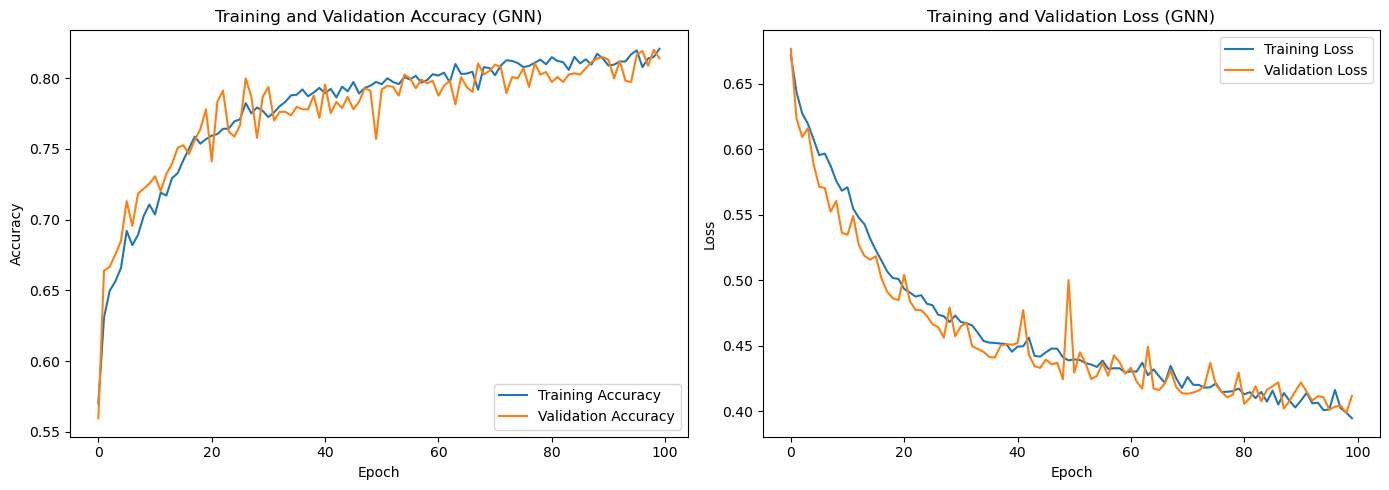

In [33]:
# create a figure with two subplots (side-by-side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) # one row, two columns

# plot accuracy
ax1.plot(train_accuracies_GNN_B3DB, label='Training Accuracy') # plot training accuracy
ax1.plot(val_accuracies_GNN_B3DB, label='Validation Accuracy') # plot validation accuracy
ax1.set_title('Training and Validation Accuracy (GNN)')
ax1.set_xlabel('Epoch') # x-axis label
ax1.set_ylabel('Accuracy') # y-axis label
ax1.legend() # add legend

# plot loss
ax2.plot(train_losses_GNN_B3DB, label='Training Loss') # plot training loss
ax2.plot(val_losses_GNN_B3DB, label='Validation Loss') # plot validation loss
ax2.set_title('Training and Validation Loss (GNN)')
ax2.set_xlabel('Epoch') # x-axis label
ax2.set_ylabel('Loss') # y-axis label
ax2.legend() # add legend

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

**Analysis**

The graph neural network (GNN) model shows strong learning dynamics and generalization ability, as illustrated by the training and validation accuracy and loss curves. In the accuracy plot (left), the model exhibits a steady increase in both training and validation accuracy, reaching around 82% by the end of training. Importantly, the validation accuracy closely tracks the training accuracy across all 100 epochs, with minimal divergence and only minor fluctuations. This alignment suggests the model is effectively learning from the structural graph-based features without overfitting, and it indicates that the GNN can generalize well to unseen molecular graphs.

The loss plot (right) further supports this conclusion. Both training and validation losses decrease consistently throughout training, with a smooth and sustained downward trend. While the validation loss shows occasional small spikes—likely due to batch-level variation in graph complexity—these deviations quickly self-correct, and the overall trajectory remains tightly coupled with that of the training loss. The absence of significant divergence between the loss curves reinforces that the GNN is stable and benefits from good regularization.

Together, these plots reflect that the GNN model is not only learning meaningful representations of molecular structure through its graph convolutional layers but also achieving performance comparable to the descriptor-based FCNN.

**GNN Evaluation**

In [34]:
# set model to evaluation mode
model_GNN_B3DB.eval()

# collect true labels and predicted probabilities
all_preds_GNN_B3DB = []
all_probs_GNN_B3DB = []
all_labels_GNN_B3DB = []

with torch.no_grad():
    for batch in val_loader_B3DB:
        batch = batch.to(device_GNN_B3DB)
        out = model_GNN_B3DB(batch)
        all_probs_GNN_B3DB.extend(out.cpu().numpy()) # predicted probabilities
        all_preds_GNN_B3DB.extend((out > 0.5).float().cpu().numpy()) # predicted labels
        all_labels_GNN_B3DB.extend(batch.y.cpu().numpy()) # true labels

**Generate and Plot Confusion Matrix**

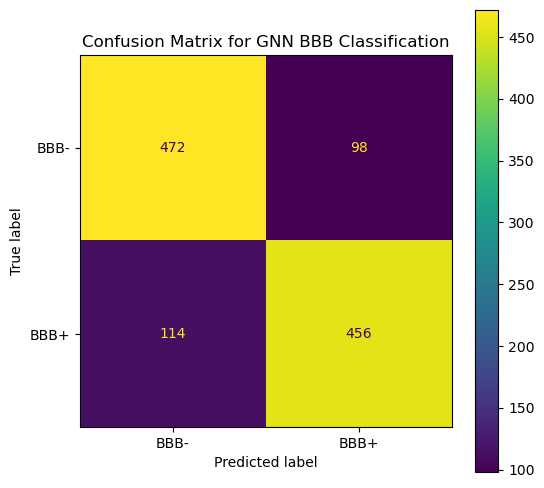

In [35]:
# create the confusion matrix
conf_matrix_GNN_B3DB = confusion_matrix(all_labels_GNN_B3DB, all_preds_GNN_B3DB) # compute confusion matrix
cm_disp_GNN_B3DB = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_GNN_B3DB, display_labels=['BBB-', 'BBB+'])

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6)) # set figure size
cm_disp_GNN_B3DB.plot(ax=ax) # plot confusion matrix on specified axes
ax.set(title='Confusion Matrix for GNN BBB Classification') # add title
plt.show() # show the plot

**Plot ROC Curve and Calculate AUC Score**

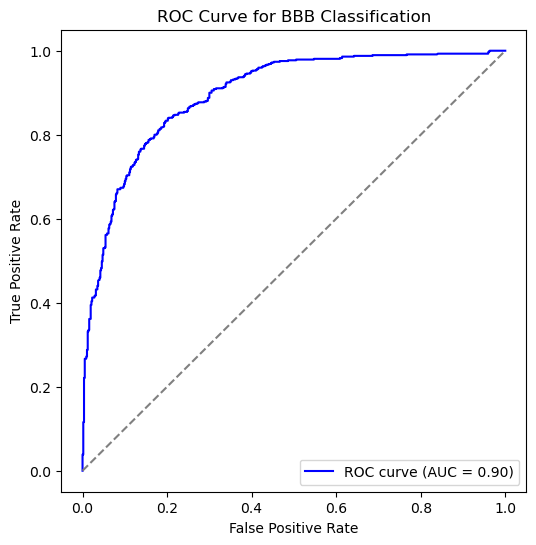

Validation AUC Score (GNN): 0.8966805170821791


In [36]:
# calculate the ROC curve points
fpr_GNN_B3DB, tpr_GNN_B3DB, thresholds_GNN_B3DB = roc_curve(all_labels_GNN_B3DB, all_probs_GNN_B3DB) # false positive rate, true positive rate

# calculate the area under the curve (AUC)
roc_auc_GNN_B3DB = auc(fpr_GNN_B3DB, tpr_GNN_B3DB) # compute AUC score

# plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6)) # set figure size
ax.plot(fpr_GNN_B3DB, tpr_GNN_B3DB, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc_GNN_B3DB)) # plot ROC curve
ax.plot([0, 1], [0, 1], color='gray', linestyle='--') # plot diagonal line for random guess
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve for BBB Classification') # set labels and title
ax.legend(loc='lower right') # place legend in lower right
plt.show() # display the plot

# print the final AUC value
print('Validation AUC Score (GNN):', roc_auc_GNN_B3DB) # print the AUC score

**Generate and Print Classification Report**

In [37]:
# generate the classification report
report_GNN_B3DB = classification_report(all_labels_GNN_B3DB, all_preds_GNN_B3DB, target_names=['BBB-', 'BBB+']) # use class names for readability

# print the classification report
print('Classification Report (GNN):\n', report_GNN_B3DB)

Classification Report (GNN):
               precision    recall  f1-score   support

        BBB-       0.81      0.83      0.82       570
        BBB+       0.82      0.80      0.81       570

    accuracy                           0.81      1140
   macro avg       0.81      0.81      0.81      1140
weighted avg       0.81      0.81      0.81      1140



**Analysis**

The evaluation metrics for the Graph Neural Network (GNN) model indicate strong and balanced classification performance on the BBB prediction task. The confusion matrix shows that the model correctly identified 472 out of 570 BBB− compounds and 456 out of 570 BBB+ compounds, suggesting that it is nearly equally capable of recognizing both classes. This balance is further reflected in the classification report, where precision, recall, and F1-scores for both BBB− and BBB+ hover around 0.81–0.82. Notably, the macro and weighted averages for these metrics are all consistent at 0.81, confirming that the model does not disproportionately favor one class over the other and maintains a high level of fairness and consistency across categories.

The ROC curve also supports the GNN model's strong discriminative ability. It demonstrates a steep rise toward the upper left corner, characteristic of a model with high sensitivity and specificity. The calculated area under the curve (AUC) is 0.897, which reflects a high overall ability of the model to distinguish between BBB− and BBB+ compounds. This strong AUC score indicates that the GNN produces well-calibrated probability estimates and maintains robust performance across a range of classification thresholds.

Overall, the confusion matrix, classification metrics, and ROC curve collectively suggest that the GNN model is both accurate and reliable for BBB classification. 

## **Evaluate Models on the CNS PET Tracer Dataset (Classification)**

To apply the previously trained FCNN and GNN models to the CNS PET tracer dataset, it is necessary to carefully process the input data to match the feature structure used during model training. The Steen_CNS_PET_tracer_data.csv file contains several molecular descriptors, but only some are directly aligned with the features used in the B3DB training set. Specifically, the dataset provides values for molecular weight (MW), topological polar surface area (TPSA), hydrogen bond donors (HBD), hydrogen bond acceptors (HBA), and several logP/logD estimates. To maintain consistency with the original model training, a set of core features must be extracted: MW, TPSA, HBD, HBA, and logP (selecting the version most comparable to previous training). Additionally, two molecular features—number of rotatable bonds and number of aromatic rings—were critical components of the B3DB feature set but are not provided directly in the Steen dataset. Therefore, SMILES strings must be processed using RDKit to calculate these missing descriptors. This approach ensures the PET tracer dataset is featurized in a way fully consistent with the B3DB-based model inputs, enabling reliable prediction of blood-brain barrier penetrability.

**Load and Process CNS PET Tracer Dataset**

In [52]:
# specify the path to the CNS PET tracer dataset
pet_tracer_path = 'data/Steen_CNS_PET_tracer_data.csv' # path to the CNS PET tracer dataset

# load the dataset using pandas with latin1 encoding
pet_df = pd.read_csv(pet_tracer_path, encoding='latin1') # read the CNS PET tracer dataset into a dataframe

# check the shape and preview the first few rows
print('Shape of CNS PET tracer dataset:', pet_df.shape) # print the shape (rows, columns)
print(pet_df.head()) # print the first five rows of the dataframe

Shape of CNS PET tracer dataset: (130, 22)
              Name                                             Smiles  \
0        [18F]ASEM  O=S1(C2=CC=C(N3C4CCN(CC4)CC3)C=C2C5=C1C(F)=CC=...   
1  [11C]CHIBA-1001                O=C(OC1=CC=C(C)C=C1)N2C3CCN(CC3)CC2   
2   [11C]Ro15 4513  O=C(N(C)CC1=C(C(OCC)=O)N=CN12)C3=C2C=CC(N=[N+]...   
3  [11C]Citalopram      FC(C=C1)=CC=C1C2(CCCN(C)C)C3=CC=C(C#N)C=C3CO2   
4   [11C]WAY100635  O=C(C1CCCCC1)N(CCN2CCN(C3=C(OC)C=CC=C3)CC2)C4=...   

  Classification     Target  MW (ChemDraw)  HBDs (ACD/Perecpta)  \
0     Successful  Ê_7 nAChR     358.431403                  0.0   
1     Successful  Ê_7 nAChR     260.337000                  0.0   
2     Successful    _5GABAA     326.316000                  0.0   
3   Unsuccessful        5HT     324.399403                  0.0   
4     Successful      5HT1A     422.573000                  0.0   

   HBAs (ACD/Percepta)  TPSA (ACD/Percepta)  LogD (ACD/Percepta)  \
0                  4.0                49.00    

In [53]:
# view the columns exactly
for idx, col in enumerate(pet_df.columns):
    print(f'{idx}: "{col}"')

0: "Name"
1: "Smiles"
2: "Classification"
3: "Target"
4: "MW (ChemDraw)"
5: "HBDs (ACD/Perecpta)"
6: "HBAs (ACD/Percepta)"
7: "TPSA (ACD/Percepta)"
8: "LogD (ACD/Percepta)"
9: "Basic pKa (ACD/Percepta)"
10: "LogP (BioLoom)"
11: "CNS MPO"
12: "CNS PET MPO"
13: "BBB score"
14: "(N+O)²5"
15: "logBB>0 (Norinder Haeberlin)"
16: "Lipinskis CNS rule"
17: "CNS access score (ACD/Percepta)"
18: "logBB (ACD/Percepta)"
19: "PPB (ACD/Percepta)"
20: "Unnamed: 20"
21: "Unnamed: 21"


In [54]:
# select relevant columns for feature extraction
selected_columns_PET = ['Name', 'Smiles', 'Classification', 'MW (ChemDraw)', 'TPSA (ACD/Percepta)', 'HBDs (ACD/Perecpta)', 'HBAs (ACD/Percepta)', 'LogP (BioLoom)', 'logBB (ACD/Percepta)'] # include Classification and logBB for later analysis

# subset the PET tracer dataframe
pet_df_selected = pet_df[selected_columns_PET] # create a subset dataframe with selected columns

# rename columns to match B3DB naming style
pet_df_selected = pet_df_selected.rename(columns={
    'Smiles': 'SMILES',
    'MW (ChemDraw)': 'MW',
    'TPSA (ACD/Percepta)': 'TopoPSA',
    'HBDs (ACD/Perecpta)': 'nHBDon', # corrected typo here
    'HBAs (ACD/Percepta)': 'nHBAcc',
    'LogP (BioLoom)': 'SLogP',
    'logBB (ACD/Percepta)': 'logBB_exp'
}) # rename columns for consistency with training set

# map Classification labels to match B3DB style
pet_df_selected['Classification'] = pet_df_selected['Classification'].map({'Successful': 'BBB+', 'Unsuccessful': 'BBB-'}) # map Successful → BBB+, Unsuccessful → BBB-

# check the resulting dataframe
print('Shape after selecting, renaming, and mapping labels:', pet_df_selected.shape) # print the shape
print(pet_df_selected.head()) # preview the first five rows

Shape after selecting, renaming, and mapping labels: (130, 9)
              Name                                             SMILES  \
0        [18F]ASEM  O=S1(C2=CC=C(N3C4CCN(CC4)CC3)C=C2C5=C1C(F)=CC=...   
1  [11C]CHIBA-1001                O=C(OC1=CC=C(C)C=C1)N2C3CCN(CC3)CC2   
2   [11C]Ro15 4513  O=C(N(C)CC1=C(C(OCC)=O)N=CN12)C3=C2C=CC(N=[N+]...   
3  [11C]Citalopram      FC(C=C1)=CC=C1C2(CCCN(C)C)C3=CC=C(C#N)C=C3CO2   
4   [11C]WAY100635  O=C(C1CCCCC1)N(CCN2CCN(C3=C(OC)C=CC=C3)CC2)C4=...   

  Classification          MW  TopoPSA  nHBDon  nHBAcc  SLogP  logBB_exp  
0           BBB+  358.431403    49.00     0.0     4.0  2.960      -0.07  
1           BBB+  260.337000    32.78     0.0     4.0  1.986       0.53  
2           BBB+  326.316000   114.18     0.0     9.0  2.004      -0.37  
3           BBB-  324.399403    32.26     0.0     3.0  3.132       0.60  
4           BBB+  422.573000    48.91     0.0     6.0  3.890      -0.03  


In [61]:
# print the class distribution of BBB+/BBB- labels in the PET tracer dataset
print('Class distribution in CNS PET tracer dataset:')
print() # empty line
print(pet_df_selected['Classification'].value_counts())

Class distribution in CNS PET tracer dataset:

Classification
BBB+    109
BBB-     20
Name: count, dtype: int64


It is worth noting that there are significantly fewer BBB- samples than there are BBB+ samples in the CNS PET tracer dataset.

In [69]:
# initialize empty lists to store new features
nRot_PET = [] # list to store number of rotatable bonds
naRing_PET = [] # list to store number of aromatic rings

# loop through each SMILES string
for smiles in pet_df_selected['SMILES']:
    if pd.isna(smiles):
        nRot_PET.append(None) # append None if SMILES is missing
        naRing_PET.append(None)
        continue # skip to the next molecule

    mol = Chem.MolFromSmiles(str(smiles)) # safely convert SMILES to RDKit molecule
    
    if mol is None:
        nRot_PET.append(None) # append None if molecule conversion fails
        naRing_PET.append(None)
    else:
        nRot = Descriptors.NumRotatableBonds(mol) # calculate number of rotatable bonds
        nAromatic = len([ring for ring in mol.GetRingInfo().AtomRings() if all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring)]) # count aromatic rings
        
        nRot_PET.append(nRot) # append number of rotatable bonds
        naRing_PET.append(nAromatic) # append number of aromatic rings

# add new features to the dataframe
pet_df_selected['nRot'] = nRot_PET # add column for rotatable bonds
pet_df_selected['naRing'] = naRing_PET # add column for aromatic rings

# check the updated dataframe
print('Shape after adding RDKit-calculated features:', pet_df_selected.shape) # print the shape
print(pet_df_selected.head()) # preview the first five rows

Shape after adding RDKit-calculated features: (129, 11)
              Name                                             SMILES  \
0        [18F]ASEM  O=S1(C2=CC=C(N3C4CCN(CC4)CC3)C=C2C5=C1C(F)=CC=...   
1  [11C]CHIBA-1001                O=C(OC1=CC=C(C)C=C1)N2C3CCN(CC3)CC2   
2   [11C]Ro15 4513  O=C(N(C)CC1=C(C(OCC)=O)N=CN12)C3=C2C=CC(N=[N+]...   
3  [11C]Citalopram      FC(C=C1)=CC=C1C2(CCCN(C)C)C3=CC=C(C#N)C=C3CO2   
4   [11C]WAY100635  O=C(C1CCCCC1)N(CCN2CCN(C3=C(OC)C=CC=C3)CC2)C4=...   

  Classification          MW  TopoPSA  nHBDon  nHBAcc  SLogP  logBB_exp  nRot  \
0           BBB+  358.431403    49.00     0.0     4.0  2.960      -0.07     1   
1           BBB+  260.337000    32.78     0.0     4.0  1.986       0.53     1   
2           BBB+  326.316000   114.18     0.0     9.0  2.004      -0.37     3   
3           BBB-  324.399403    32.26     0.0     3.0  3.132       0.60     5   
4           BBB+  422.573000    48.91     0.0     6.0  3.890      -0.03     7   

   naRing  
0     

In [70]:
# drop any rows with missing values in important columns
pet_df_selected = pet_df_selected.dropna(subset=['MW', 'TopoPSA', 'nHBDon', 'nHBAcc', 'SLogP', 'nRot', 'naRing']) # drop rows with missing features

# reset index after dropping rows
pet_df_selected = pet_df_selected.reset_index(drop=True) # reset the index for cleanliness

# check the final cleaned dataframe
print('Shape after dropping incomplete rows:', pet_df_selected.shape) # print the shape
print(pet_df_selected.head()) # preview the first five rows

Shape after dropping incomplete rows: (129, 11)
              Name                                             SMILES  \
0        [18F]ASEM  O=S1(C2=CC=C(N3C4CCN(CC4)CC3)C=C2C5=C1C(F)=CC=...   
1  [11C]CHIBA-1001                O=C(OC1=CC=C(C)C=C1)N2C3CCN(CC3)CC2   
2   [11C]Ro15 4513  O=C(N(C)CC1=C(C(OCC)=O)N=CN12)C3=C2C=CC(N=[N+]...   
3  [11C]Citalopram      FC(C=C1)=CC=C1C2(CCCN(C)C)C3=CC=C(C#N)C=C3CO2   
4   [11C]WAY100635  O=C(C1CCCCC1)N(CCN2CCN(C3=C(OC)C=CC=C3)CC2)C4=...   

  Classification          MW  TopoPSA  nHBDon  nHBAcc  SLogP  logBB_exp  nRot  \
0           BBB+  358.431403    49.00     0.0     4.0  2.960      -0.07     1   
1           BBB+  260.337000    32.78     0.0     4.0  1.986       0.53     1   
2           BBB+  326.316000   114.18     0.0     9.0  2.004      -0.37     3   
3           BBB-  324.399403    32.26     0.0     3.0  3.132       0.60     5   
4           BBB+  422.573000    48.91     0.0     6.0  3.890      -0.03     7   

   naRing  
0       2  
1 

**Predicting BBB Penetrability of CNS PET Tracers Using Trained Neural Networks**

In [71]:
# select only the feature columns used during training
X_PET = pet_df_selected[['MW', 'TopoPSA', 'nHBDon', 'nHBAcc', 'SLogP', 'nRot', 'naRing']] # select relevant features for scaling

# apply the scaler fitted on B3DB training data
X_PET_scaled = pd.DataFrame(scaler_B3DB.transform(X_PET), columns=X_PET.columns, index=pet_df_selected.index) # apply the same scaler and wrap back into DataFrame

# check the shape of the scaled PET tracer feature set
print('Shape of scaled CNS PET tracer feature set:', X_PET_scaled.shape) # print the shape
print(X_PET_scaled.head()) # preview the first five rows

Shape of scaled CNS PET tracer feature set: (129, 7)
         MW   TopoPSA    nHBDon    nHBAcc     SLogP      nRot    naRing
0 -0.244176 -0.726215 -0.928515 -0.488932  0.340796 -1.074181  0.601272
1 -0.789438 -0.933484 -0.928515 -0.488932 -0.077276 -1.074181 -0.316533
2 -0.422690  0.106697 -0.928515  0.768976 -0.069550 -0.543490  0.601272
3 -0.433344 -0.940129 -0.928515 -0.740513  0.414624 -0.012799  0.601272
4  0.112358 -0.727365 -0.928515  0.014231  0.739982  0.517892  0.601272


In [72]:
# extract the true BBB classification labels for PET tracers
y_PET_true = pet_df_selected['Classification'] # extract the ground-truth BBB+/BBB- labels

# check the shape and preview the first few labels
print('Shape of true PET tracer labels:', y_PET_true.shape) # print the shape
print(y_PET_true.head()) # preview the first five labels

Shape of true PET tracer labels: (129,)
0    BBB+
1    BBB+
2    BBB+
3    BBB-
4    BBB+
Name: Classification, dtype: object


**Predicting BBB Penetrability of CNS PET Tracers Using FCNN**

In [73]:
# use the trained FCNN model to predict on the CNS PET tracer data
y_PET_pred_probs_FCNN = model_FCNN.predict(X_PET_scaled) # predict probabilities for each tracer

# convert probabilities to binary labels (threshold at 0.5)
y_PET_pred_labels_FCNN = (y_PET_pred_probs_FCNN > 0.5).astype(int).flatten() # threshold and flatten predictions

# map predicted labels back to BBB+/BBB- for consistency
y_PET_pred_labels_FCNN = pd.Series(np.where(y_PET_pred_labels_FCNN == 1, 'BBB+', 'BBB-'), index=X_PET_scaled.index) # map 1 → BBB+, 0 → BBB-

# check the shape and preview predicted labels
print('Shape of predicted PET tracer labels (FCNN):', y_PET_pred_labels_FCNN.shape) # print the shape
print(y_PET_pred_labels_FCNN.head()) # preview the first five predicted labels

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Shape of predicted PET tracer labels (FCNN): (129,)
0    BBB+
1    BBB+
2    BBB+
3    BBB+
4    BBB+
dtype: object


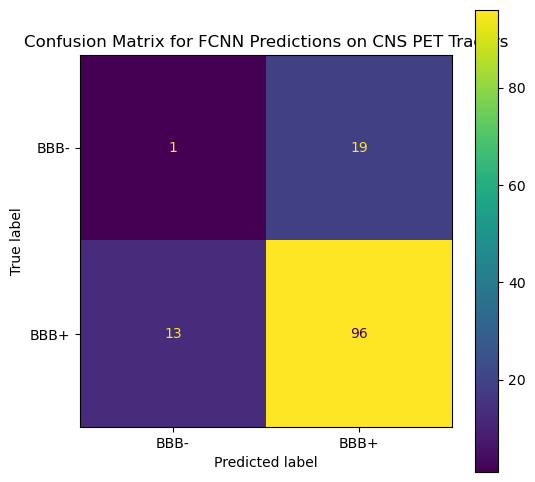

Classification Report (FCNN on PET Tracers):
               precision    recall  f1-score   support

        BBB-       0.83      0.88      0.86       109
        BBB+       0.07      0.05      0.06        20

    accuracy                           0.75       129
   macro avg       0.45      0.47      0.46       129
weighted avg       0.72      0.75      0.73       129

AUC Score (FCNN on PET Tracers): 0.3568807339449541


In [78]:
# convert ground truth to binary format for evaluation
y_PET_true_binary = np.where(y_PET_true == 'BBB+', 1, 0) # 'BBB+' → 1, 'BBB-' → 0

# generate confusion matrix
conf_matrix_FCNN = confusion_matrix(y_PET_true, y_PET_pred_labels_FCNN, labels=['BBB-', 'BBB+']) # compute confusion matrix
cm_disp_FCNN = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_FCNN, display_labels=['BBB-', 'BBB+']) # create display object

# plot confusion matrix 
fig, ax = plt.subplots(figsize=(6, 6)) # set figure size
cm_disp_FCNN.plot(ax=ax) # plot on axes
ax.set(title='Confusion Matrix for FCNN Predictions on CNS PET Tracers') # add title
plt.show()

# generate and print classification report
report_FCNN = classification_report(y_PET_true, y_PET_pred_labels_FCNN, target_names=['BBB-', 'BBB+']) # generate classification report
print('Classification Report (FCNN on PET Tracers):\n', report_FCNN)

# calculate and print AUC score (use predicted probabilities)
roc_auc_FCNN_pet = roc_auc_score(y_PET_true_binary, y_PET_pred_probs_FCNN) # compute AUC from probabilities
print('AUC Score (FCNN on PET Tracers):', roc_auc_FCNN_pet)

**Analysis**

The FCNN’s performance on the CNS PET tracer dataset reveals a substantial failure to generalize beyond the B3DB training distribution, particularly in detecting BBB− compounds. The confusion matrix shows that nearly all BBB− tracers (19 out of 20) were misclassified as BBB+, indicating the model has developed a strong bias toward predicting the majority class. This is reflected in the classification report, where the precision, recall, and F1-score for BBB− are extremely low (all ≈ 0.06–0.07), while the BBB+ class shows superficially high scores but is misleading given its overwhelming dominance in the dataset.

Despite a deceptively high overall accuracy of 75%, the macro-averaged and AUC metrics tell a more truthful story. The macro F1-score is just 0.46, and the AUC score of 0.36 is well below random, confirming that the model struggles to meaningfully distinguish between the two classes. This likely results from overfitting to the training distribution and poor handling of class imbalance in this external, real-world dataset. Overall, these findings suggest that the FCNN lacks generalizability to PET tracer compounds and underscores the need for improved domain adaptation or more chemically diverse training data.

**Predicting BBB Penetrability of CNS PET Tracers Using GNN**

In [79]:
# set GNN model to evaluation mode
model_GNN_B3DB.eval() # set model to evaluation mode

# initialize lists to collect predictions and true labels
all_preds_GNN = [] # list to store predicted probabilities (sigmoid outputs)
all_labels_GNN = [] # list to store true binary labels (0 for BBB-, 1 for BBB+)

# no gradient computation needed during evaluation
with torch.no_grad():
    for i, row in pet_df_selected.iterrows():
        smiles = row['SMILES'] # get SMILES string
        label_str = row['Classification'] # get ground truth label
        label = 1 if label_str == 'BBB+' else 0 # convert to binary

        mol = Chem.MolFromSmiles(smiles) # convert SMILES to RDKit Mol object
        if mol is None:
            continue # skip invalid molecules

        # use the same featurization as training
        data = mol_to_pyg_data_B3DB(mol, label) # reuse the same featurization function
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long) # simulate batch index

        data = data.to(device_GNN_B3DB) # move data to same device as model

        out = model_GNN_B3DB(data) # forward pass
        pred_prob = out.cpu().item() # get scalar prediction
        pred_label = 1 if pred_prob > 0.5 else 0 # apply threshold

        all_preds_GNN.append(pred_prob) # store predicted probability
        all_labels_GNN.append(label)    # store true label

# convert predicted labels to 'BBB+' / 'BBB-' format
y_PET_pred_labels_GNN = pd.Series(np.where(np.array(all_preds_GNN) > 0.5, 'BBB+', 'BBB-'), index=pet_df_selected.index)

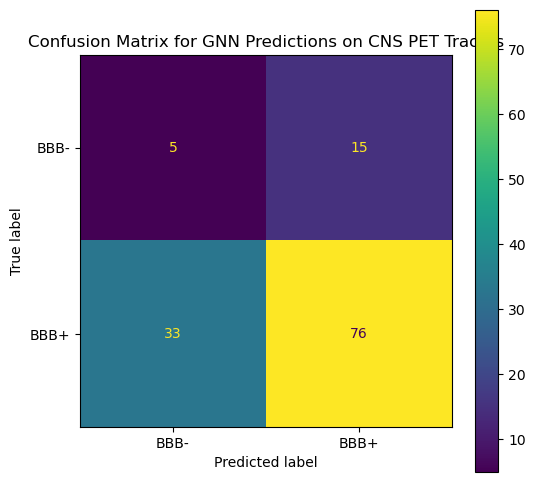

Classification Report (GNN on PET Tracers):
               precision    recall  f1-score   support

        BBB-       0.84      0.70      0.76       109
        BBB+       0.13      0.25      0.17        20

    accuracy                           0.63       129
   macro avg       0.48      0.47      0.47       129
weighted avg       0.73      0.63      0.67       129

AUC Score (GNN on PET Tracers): 0.4747706422018349


In [80]:
# generate the confusion matrix
conf_matrix_GNN = confusion_matrix(y_PET_true, y_PET_pred_labels_GNN, labels=['BBB-', 'BBB+']) # compute confusion matrix

# create a display object for the confusion matrix
cm_disp_GNN = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_GNN, display_labels=['BBB-', 'BBB+'])

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6)) # set figure size
cm_disp_GNN.plot(ax=ax) # plot confusion matrix on specified axes
ax.set(title='Confusion Matrix for GNN Predictions on CNS PET Tracers') # add title
plt.show() # show the plot

# generate and print the classification report
report_GNN = classification_report(y_PET_true, y_PET_pred_labels_GNN, target_names=['BBB-', 'BBB+']) # use class names
print('Classification Report (GNN on PET Tracers):\n', report_GNN) # print report

# calculate and print AUC score
y_PET_true_binary = np.where(y_PET_true == 'BBB+', 1, 0) # convert ground truth to binary
roc_auc_GNN_pet = roc_auc_score(y_PET_true_binary, all_preds_GNN) # compute AUC
print('AUC Score (GNN on PET Tracers):', roc_auc_GNN_pet) # print AUC score

**Analysis**

The GNN model demonstrates somewhat better generalization to the CNS PET tracer dataset than the FCNN, particularly in its ability to identify a subset of BBB− compounds. The confusion matrix shows that 5 out of 20 BBB− tracers were correctly classified, compared to just 1 with the FCNN. However, the majority of BBB− compounds are still misclassified as BBB+, and the model also mislabels a large number of true BBB+ compounds as BBB−. This bidirectional misclassification indicates a lack of robust discriminative capability across both classes.

The classification report highlights the imbalance in performance: while the model achieves a relatively strong precision and recall for the majority BBB− class (0.84 and 0.70, respectively), its performance for the minority BBB+ class is quite weak, with a precision of 0.13 and recall of 0.25. This leads to a macro-averaged F1-score of just 0.47, and a modest overall accuracy of 63%. The AUC score of 0.47—slightly below random guessing—further confirms that the model is not consistently ranking BBB+ tracers with higher predicted probabilities than BBB− ones.

Overall, while the GNN shows marginally improved recall on the minority class and slightly more balanced prediction errors than the FCNN, it still exhibits poor generalization.

## **Model Comparison and Next Steps**

While both the FCNN and GNN models exhibited poor predictive performance when applied to the BBB penetrability classification of CNS PET tracers, the GNN demonstrated slightly better generalization. In particular, it achieved higher recall and precision for the minority BBB− class and a more balanced error distribution overall. Given this modest improvement, we have chosen to proceed with a GNN structure for the next phase of our analysis. Although its classification performance was limited, we will re-train the GNN as a regression model using the B3DB dataset, this time with experimentally measured logBB values as the prediction target.

## **Predicting Continuous logBB Values Using the GNN Model**

**Load the B3DB Extended Regression Dataset**

In [82]:
# specify the path to the extended regression file
regression_extended_path_B3DB = 'data/B3DB_regression_extended.tsv.gz' # path to the extended regression file

# load the dataset using pandas, with tab separator and gzip compression
reg_ext_df_B3DB = pd.read_csv(regression_extended_path_B3DB, sep='\t', compression='gzip') # read the regression dataset into a dataframe

# check the shape of the extended regression dataset
print('Shape of extended regression dataset:', reg_ext_df_B3DB.shape) # print the shape (rows, columns)

# view the first few rows of the extended regression dataset
print(reg_ext_df_B3DB.head()) # print the first five rows of the dataframe

Shape of extended regression dataset: (1058, 1623)
   NO.                                      compound_name  \
0    1                                         moxalactam   
1    2                                      schembl614298   
2    3                             morphine-6-glucuronide   
3    4  2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...   
4    5                                                NaN   

                                          IUPAC_name  \
0  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...   
1  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...   
2  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-9-hydro...   
3  2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...   
4                                                NaN   

                                              SMILES          CID  logBB  \
0  CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...      3889.0|  -2.52   
1  CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...  18595497.0|  -2.15   
2  CN1CC[C@]23[C@

/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/395910471.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  reg_ext_df_B3DB = pd.read_csv(regression_extended_path_B3DB, sep='\t', compression='gzip') # read the regression dataset into a dataframe


**Filter and Prepare Molecule Graphs for Regression**

In [83]:
# drop any rows with missing SMILES or logBB values
reg_ext_df_B3DB = reg_ext_df_B3DB.dropna(subset=['SMILES', 'logBB'])

# reset index after dropping rows
reg_ext_df_B3DB = reg_ext_df_B3DB.reset_index(drop=True)

# check updated shape
print('Shape after removing missing values:', reg_ext_df_B3DB.shape)

Shape after removing missing values: (1058, 1623)


**Convert Molecules to PyTorch Geometric Graphs**

In [84]:
# initialize empty list to store graph Data objects
data_list_logBB = []

# loop through rows of the filtered dataframe
for i, row in tqdm(reg_ext_df_B3DB.iterrows(), total=len(reg_ext_df_B3DB)):
    smiles = row['SMILES']
    logBB = row['logBB']

    mol = Chem.MolFromSmiles(smiles)  # convert SMILES to RDKit molecule

    if mol is None:
        continue  # skip invalid SMILES

    data = mol_to_pyg_data_B3DB(mol, logBB)  # reuse existing graph construction function
    data_list_logBB.append(data)

# print how many molecules were successfully converted
print('Number of Molecule Graphs Created for logBB:', len(data_list_logBB))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1058/1058 [00:00<00:00, 2064.20it/s]

Number of Molecule Graphs Created for logBB: 1058


**Create Dataset and Split into Train/Validation Sets**

In [85]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

In [86]:
# define a simple in-memory dataset wrapper for logBB graphs
class MoleculeDataset_logBB(InMemoryDataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list  # list of PyG Data objects

    def len(self):
        return len(self.data_list)  # number of molecules

    def get(self, idx):
        return self.data_list[idx]  # retrieve individual Data object by index

In [87]:
# wrap the list of molecule graphs into a PyTorch Geometric dataset
full_dataset_logBB = MoleculeDataset_logBB(data_list_logBB)

In [88]:
# split indices into training (80%) and validation (20%)
train_idx_logBB, val_idx_logBB = train_test_split(range(len(full_dataset_logBB)), test_size=0.2, random_state=2025)

In [89]:
# create training and validation subsets
train_dataset_logBB = torch.utils.data.Subset(full_dataset_logBB, train_idx_logBB)
val_dataset_logBB = torch.utils.data.Subset(full_dataset_logBB, val_idx_logBB)

In [90]:
# wrap subsets into DataLoaders
train_loader_logBB = DataLoader(train_dataset_logBB, batch_size=32, shuffle=True)
val_loader_logBB = DataLoader(val_dataset_logBB, batch_size=32, shuffle=False)

In [91]:
# print how many samples are in each subset
print('Training samples (logBB):', len(train_dataset_logBB))
print('Validation samples (logBB):', len(val_dataset_logBB))

Training samples (logBB): 846
Validation samples (logBB): 212


**Define GNN Model for Regression of logBB Values**

In [92]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.nn.models import MLP

In [93]:
# define a graph neural network model for predicting continuous logBB values
class GNN_logBB(nn.Module):
    def __init__(self):
        super(GNN_logBB, self).__init__()

        # define the first MLP to transform input atom features before first GINEConv
        mlp1 = MLP([7, 64], norm=None)  # 7 input features → 64 hidden

        # define the second MLP to transform features before second GINEConv
        mlp2 = MLP([64, 32], norm=None)  # 64 → 32

        # two GINEConv layers with rich bond (edge) features (dim = 6)
        self.conv1 = GINEConv(nn=mlp1, edge_dim=6)  # first graph convolution
        self.conv2 = GINEConv(nn=mlp2, edge_dim=6)  # second graph convolution

        # global pooling followed by dense layers
        self.fc1 = nn.Linear(32, 16)  # compress pooled graph representation
        self.fc2 = nn.Linear(16, 1)   # output scalar for regression (logBB value)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # apply first graph convolution + ReLU
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)

        # apply second graph convolution + ReLU
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        # apply global mean pooling to get one vector per graph
        x = global_mean_pool(x, batch)

        # apply dense layers
        x = self.fc1(x)
        x = F.relu(x)

        # final prediction (no activation for regression)
        x = self.fc2(x)

        return x.view(-1)  # flatten output to shape (batch,)

**Train the GNN Model to Predict logBB Values**

In [94]:
# initialize the GNN regression model
model_GNN_logBB = GNN_logBB()

# choose the computation device (GPU if available, else CPU)
device_GNN_logBB = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GNN_logBB = model_GNN_logBB.to(device_GNN_logBB)  # move model to device

# define mean squared error loss and optimizer
criterion_GNN_logBB = nn.MSELoss()  # use MSE for regression
optimizer_GNN_logBB = torch.optim.Adam(model_GNN_logBB.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# set number of training epochs
num_epochs_GNN_logBB = 100

In [95]:
# lists to store training and validation losses for visualization
train_losses_GNN_logBB = []
val_losses_GNN_logBB = []

# start training loop
for epoch in range(1, num_epochs_GNN_logBB + 1):
    model_GNN_logBB.train()  # set model to training mode
    epoch_loss = 0

    for batch in train_loader_logBB:
        batch = batch.to(device_GNN_logBB)  # move batch to device
        optimizer_GNN_logBB.zero_grad()     # reset gradients

        out = model_GNN_logBB(batch)        # forward pass
        loss = criterion_GNN_logBB(out, batch.y.view(-1))  # compute MSE loss

        loss.backward()                     # backpropagation
        optimizer_GNN_logBB.step()          # update weights

        epoch_loss += loss.item() * batch.num_graphs  # accumulate loss (scaled by number of graphs)

    # compute average training loss
    train_loss = epoch_loss / len(train_loader_logBB.dataset)
    train_losses_GNN_logBB.append(train_loss)

    # validation phase (no gradient computation)
    model_GNN_logBB.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader_logBB:
            batch = batch.to(device_GNN_logBB)
            out = model_GNN_logBB(batch)
            loss = criterion_GNN_logBB(out, batch.y.view(-1))
            val_loss += loss.item() * batch.num_graphs

    # compute average validation loss
    val_loss /= len(val_loader_logBB.dataset)
    val_losses_GNN_logBB.append(val_loss)

    # print epoch summary
    print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

Epoch 001 | Train Loss: 0.5787 | Val Loss: 0.5806
Epoch 002 | Train Loss: 0.5574 | Val Loss: 0.5710
Epoch 003 | Train Loss: 0.5384 | Val Loss: 0.5553
Epoch 004 | Train Loss: 0.5466 | Val Loss: 0.5799
Epoch 005 | Train Loss: 0.5421 | Val Loss: 0.5716
Epoch 006 | Train Loss: 0.5341 | Val Loss: 0.5754
Epoch 007 | Train Loss: 0.5319 | Val Loss: 0.5440
Epoch 008 | Train Loss: 0.5130 | Val Loss: 0.5698
Epoch 009 | Train Loss: 0.5254 | Val Loss: 0.5396
Epoch 010 | Train Loss: 0.5190 | Val Loss: 0.5323
Epoch 011 | Train Loss: 0.5186 | Val Loss: 0.5400
Epoch 012 | Train Loss: 0.5154 | Val Loss: 0.5411
Epoch 013 | Train Loss: 0.5145 | Val Loss: 0.5247
Epoch 014 | Train Loss: 0.4953 | Val Loss: 0.5139
Epoch 015 | Train Loss: 0.5027 | Val Loss: 0.5090
Epoch 016 | Train Loss: 0.4961 | Val Loss: 0.5220
Epoch 017 | Train Loss: 0.5024 | Val Loss: 0.5024
Epoch 018 | Train Loss: 0.4810 | Val Loss: 0.4971
Epoch 019 | Train Loss: 0.4791 | Val Loss: 0.5093
Epoch 020 | Train Loss: 0.4734 | Val Loss: 0.4904


**Plot Training and Validation Loss Curves**

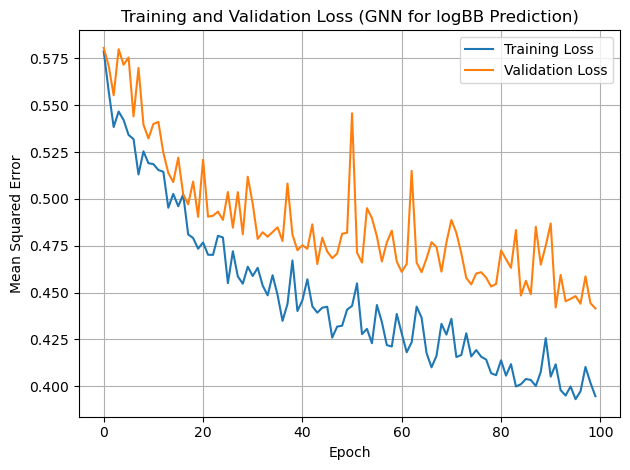

In [97]:
# create a plot to compare training and validation loss over epochs
plt.figure()  # set figure size

# plot training loss
plt.plot(train_losses_GNN_logBB, label='Training Loss')

# plot validation loss
plt.plot(val_losses_GNN_logBB, label='Validation Loss')

# customize the plot
plt.title('Training and Validation Loss (GNN for logBB Prediction)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.tight_layout()

# display the plot
plt.show()

**Analysis**

The training and validation loss curves for the GNN regression model reveal a clear downward trajectory in training loss, indicating that the model steadily learns from the data across the 100 training epochs. The validation loss generally follows the same decreasing trend, although it exhibits greater variability, particularly between epochs 30 and 70. Despite these fluctuations, the validation loss does not diverge significantly from the training loss, suggesting that the model does not suffer from severe overfitting. Notably, in the final epochs, both curves appear to stabilize, with validation loss plateauing slightly above the training curve. This overall pattern reflects a healthy learning process, with room for potential improvement through techniques like early stopping or regularization, but no major issues with convergence or generalization failure.

## **Evaluate GNN Model on the CNS PET Tracer Dataset (Regression)**

**Load and Process CNS PET Tracer Dataset**

In [99]:
# specify the path to the CNS PET tracer dataset
pet_tracer_path = 'data/Steen_CNS_PET_tracer_data.csv' # path to the CNS PET tracer dataset

# load the dataset using pandas with latin1 encoding
pet_df = pd.read_csv(pet_tracer_path, encoding='latin1') # read the CNS PET tracer dataset into a dataframe

In [100]:
# select only the necessary columns: SMILES for molecular structure and logBB for the regression target
pet_df_logBB = pet_df[['Smiles', 'logBB (ACD/Percepta)']].copy()  # subset relevant columns

# rename columns for consistency with the GNN featurization function
pet_df_logBB = pet_df_logBB.rename(columns={
    'Smiles': 'SMILES',
    'logBB (ACD/Percepta)': 'logBB_exp'
})  # rename to match expected column names

# drop rows with missing values in SMILES or logBB
pet_df_logBB = pet_df_logBB.dropna(subset=['SMILES', 'logBB_exp'])  # drop rows missing either SMILES or logBB

# reset index for clean iteration
pet_df_logBB = pet_df_logBB.reset_index(drop=True)  # reset index after cleaning

# preview cleaned dataset
print('Shape of cleaned PET tracer dataset for logBB prediction:', pet_df_logBB.shape)
print(pet_df_logBB.head())

Shape of cleaned PET tracer dataset for logBB prediction: (129, 2)
                                              SMILES  logBB_exp
0  O=S1(C2=CC=C(N3C4CCN(CC4)CC3)C=C2C5=C1C(F)=CC=...      -0.07
1                O=C(OC1=CC=C(C)C=C1)N2C3CCN(CC3)CC2       0.53
2  O=C(N(C)CC1=C(C(OCC)=O)N=CN12)C3=C2C=CC(N=[N+]...      -0.37
3      FC(C=C1)=CC=C1C2(CCCN(C)C)C3=CC=C(C#N)C=C3CO2       0.60
4  O=C(C1CCCCC1)N(CCN2CCN(C3=C(OC)C=CC=C3)CC2)C4=...      -0.03


**Convert PET Tracer SMILES into Graphs for GNN Prediction**

In [101]:
# initialize an empty list to store graph data objects
pet_data_list_logBB = []

# loop through each row in the PET tracer dataframe
for i, row in pet_df_logBB.iterrows():
    smiles = row['SMILES']                      # extract SMILES string
    logBB = row['logBB_exp']                    # extract experimental logBB value

    mol = Chem.MolFromSmiles(smiles)            # convert SMILES to RDKit molecule
    if mol is None:
        continue                                # skip invalid SMILES strings

    data = mol_to_pyg_data_B3DB(mol, logBB)     # reuse GNN-compatible featurization function
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)  # assign batch index (required for model)

    pet_data_list_logBB.append(data)            # add to the graph list

# print number of successfully processed molecules
print('Number of valid PET tracer graphs constructed for logBB prediction:', len(pet_data_list_logBB))

Number of valid PET tracer graphs constructed for logBB prediction: 129


**Predict logBB Values for PET Tracers Using Trained GNN Model**

In [102]:
# set the model to evaluation mode
model_GNN_logBB.eval()

# initialize empty lists to store predictions and true values
logBB_preds = []    # predicted logBB values
logBB_true = []     # true logBB values from the dataset

# disable gradient tracking during inference
with torch.no_grad():
    for data in pet_data_list_logBB:
        data = data.to(device_GNN_logBB)        # move data to same device as model

        out = model_GNN_logBB(data)             # perform forward pass
        pred = out.cpu().item()                 # convert prediction to scalar

        logBB_preds.append(pred)                # store prediction
        logBB_true.append(data.y.item())        # store ground-truth logBB

**Evaluate and Visualize GNN logBB Predictions on PET Tracers**

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [107]:
# calculate regression evaluation metrics
mse_pet = mean_squared_error(logBB_true, logBB_preds)     # Mean Squared Error
mae_pet = mean_absolute_error(logBB_true, logBB_preds)    # Mean Absolute Error
r2_pet = r2_score(logBB_true, logBB_preds)                # R-squared score

# print the evaluation results
print('Evaluation on CNS PET Tracers (GNN logBB Regression):')
print('Mean Squared Error (MSE):', mse_pet)
print('Mean Absolute Error (MAE):', mae_pet)
print('R-squared (R²):', r2_pet)

Evaluation on CNS PET Tracers (GNN logBB Regression):
Mean Squared Error (MSE): 0.33991257650186574
Mean Absolute Error (MAE): 0.48033357030430507
R-squared (R²): -0.3368825765295256


**Plot Predicted vs. True logBB Values**

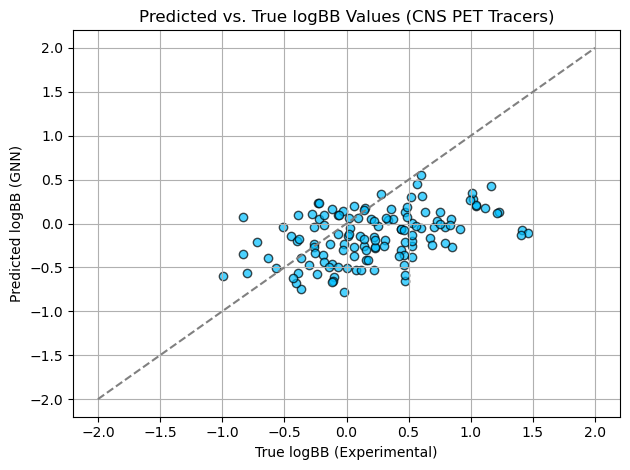

In [118]:
# create a scatter plot of predicted vs. true logBB values
plt.figure()
plt.scatter(logBB_true, logBB_preds, alpha=0.7, color='deepskyblue', edgecolor='k')  # scatter plot
plt.plot([-2, 2], [-2, 2], color='gray', linestyle='--')  # y = x reference line

# add plot annotations
plt.xlabel('True logBB (Experimental)')
plt.ylabel('Predicted logBB (GNN)')
plt.title('Predicted vs. True logBB Values (CNS PET Tracers)')
plt.grid(True)
plt.tight_layout()

# show the plot
plt.show()

## **Analysis of GNN logBB Prediction and Next Steps**

**Analysis**

The GNN model’s performance on predicting experimental logBB values for CNS PET tracers reveals substantial limitations in generalizability. As shown in the scatter plot, most predictions cluster around a narrow band near zero, with significant deviation from the ideal diagonal line (y = x), especially at higher and lower logBB values. This suggests the model struggles to capture the full dynamic range of the data and tends to regress toward the mean. Quantitatively, the model yields a mean squared error (MSE) of 0.340 and a mean absolute error (MAE) of approximately 0.48, indicating moderate average deviations between predicted and true values. However, the negative R² score of −0.34 confirms that the model performs worse than a simple mean predictor, highlighting poor explanatory power on this external dataset. Overall, these findings suggest that while the GNN may have captured patterns in the B3DB training set, it fails to transfer that knowledge effectively to chemically distinct PET tracers, likely due to distributional shift or insufficient representation of relevant chemotypes in the training data.

**Next Steps**

Given the GNN model’s poor performance in predicting experimental logBB values for CNS PET tracers—reflected by its negative R² score and substantial prediction error—we now explore an alternative approach. Specifically, we will train a fully connected neural network (FCNN) using molecular descriptors from the B3DB regression dataset to evaluate whether a descriptor-based model can yield improved predictive performance. This parallel analysis will help assess whether traditional feature engineering offers better generalizability for logBB regression than graph-based representations in this context.

## **Predicting Continuous logBB Values Using the FCNN Model**

**Load and Process B3DB Regression Dataset for FCNN**

In [121]:
# specify the path to the extended regression file
regression_extended_path_B3DB = 'data/B3DB_regression_extended.tsv.gz'  # path to the extended regression dataset

# load the dataset using pandas (tab-separated, gzipped)
reg_ext_df_B3DB = pd.read_csv(regression_extended_path_B3DB, sep='\t', compression='gzip')  # load dataset

# print dataset shape
print('Shape of regression dataset:', reg_ext_df_B3DB.shape)

Shape of regression dataset: (1058, 1623)


/var/folders/bd/jk2flm0n6v7chkqsznqx3b3h0000gn/T/ipykernel_45720/1172029056.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  reg_ext_df_B3DB = pd.read_csv(regression_extended_path_B3DB, sep='\t', compression='gzip')  # load dataset


**Select Descriptor Features and logBB Target**

In [122]:
# define descriptor columns to be used as input features
selected_features_regression_B3DB = ['MW', 'TopoPSA', 'nHBDon', 'nHBAcc', 'SLogP', 'nRot', 'naRing']

# select features (X) and the continuous target logBB (y)
X_regression_B3DB = reg_ext_df_B3DB[selected_features_regression_B3DB]
y_regression_B3DB = reg_ext_df_B3DB['logBB']  # continuous target

# check the shape and a preview
print('Shape of feature matrix:', X_regression_B3DB.shape)
print('Shape of target vector:', y_regression_B3DB.shape)

Shape of feature matrix: (1058, 7)
Shape of target vector: (1058,)


In [123]:
print(X_regression_B3DB.head())

           MW  TopoPSA  nHBDon  nHBAcc    SLogP  nRot  naRing
0  520.101247   231.60       4      12 -1.12770     9       2
1  461.168581   149.15       5       9 -1.23650     3       1
2  461.168581   149.15       5       9 -0.88540     3       1
3  445.147723    78.94       3       5  2.63014     8       2
4  375.073432   117.51       2       8  1.31860     2       3


In [124]:
print(y_regression_B3DB.head())

0   -2.52
1   -2.15
2   -2.09
3   -1.88
4   -1.82
Name: logBB, dtype: float64


**Split Data into Training and Validation Sets & Scale Features**

In [125]:
# split into 80% training and 20% validation
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_regression_B3DB, y_regression_B3DB, test_size=0.2, random_state=2025)

In [126]:
# initialize and fit the scaler on training data
scaler_reg = StandardScaler()
scaler_reg.fit(X_train_reg)

# apply scaler to both training and validation sets
X_train_scaled_reg = pd.DataFrame(scaler_reg.transform(X_train_reg), columns=X_train_reg.columns, index=X_train_reg.index)
X_val_scaled_reg = pd.DataFrame(scaler_reg.transform(X_val_reg), columns=X_val_reg.columns, index=X_val_reg.index)

In [127]:
# check shapes of scaled sets
print('Scaled training set shape:', X_train_scaled_reg.shape)
print('Scaled validation set shape:', X_val_scaled_reg.shape)

Scaled training set shape: (846, 7)
Scaled validation set shape: (212, 7)


**Build FCNN Model for logBB Regression**

In [128]:
# initialize a Sequential model for regression
model_FCNN_logBB = Sequential()

# first hidden layer with ReLU activation
model_FCNN_logBB.add(Dense(64, activation='relu', input_shape=(X_train_scaled_reg.shape[1],)))
model_FCNN_logBB.add(Dropout(0.3))  # dropout for regularization

# second hidden layer
model_FCNN_logBB.add(Dense(32, activation='relu'))

# output layer with linear activation for regression
model_FCNN_logBB.add(Dense(1, activation='linear'))

# compile model with mean squared error loss and Adam optimizer
model_FCNN_logBB.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# print model architecture summary
model_FCNN_logBB.summary()

/Users/andrewlevy/anaconda3/envs/QBIO465_final_project/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train FCNN Model on logBB Data**

In [129]:
# train the model and store training history
history_FCNN_logBB = model_FCNN_logBB.fit(X_train_scaled_reg, y_train_reg, validation_data=(X_val_scaled_reg, y_val_reg), epochs=100, batch_size=32,verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5441 - mae: 0.5665 - val_loss: 0.4087 - val_mae: 0.5041
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4200 - mae: 0.5181 - val_loss: 0.3969 - val_mae: 0.4936
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3977 - mae: 0.4843 - val_loss: 0.3882 - val_mae: 0.4846
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4093 - mae: 0.4924 - val_loss: 0.3813 - val_mae: 0.4816
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3628 - mae: 0.4712 - val_loss: 0.3700 - val_mae: 0.4761
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4099 - mae: 0.4896 - val_loss: 0.3691 - val_mae: 0.4751
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3663 - mae: 0.4492 - val_loss: 0.3648 - val_mae: 0.4699
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3393 - mae: 0.4468 - val_loss: 0.3594 - val_mae: 0.4645
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.341

**Plot Training and Validation Loss (FCNN for logBB Prediction)**

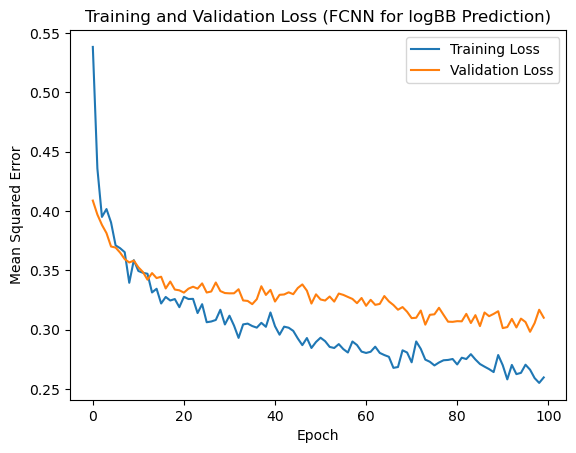

In [130]:
# create figure and axes
fig, ax = plt.subplots()

# plot training and validation loss over epochs
ax.plot(history_FCNN_logBB.history['loss'], label='Training Loss')
ax.plot(history_FCNN_logBB.history['val_loss'], label='Validation Loss')

# set labels, title, and legend
ax.set_title('Training and Validation Loss (FCNN for logBB Prediction)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')
ax.legend()

# display the plot
plt.show()

**Analysis**

The training and validation loss curves for the FCNN logBB regression model demonstrate a clear learning trend and generalization behavior. During the initial epochs, both losses decrease sharply, indicating rapid convergence as the model begins to capture fundamental patterns in the data. After around 20 epochs, the validation loss curve flattens and begins to decline more gradually, mirroring the continued improvement seen in the training loss. Importantly, while the training loss continues to drop steadily, the validation loss does not diverge, suggesting that overfitting is being effectively mitigated. The presence of small oscillations in the validation curve is expected given the variability in batch composition, but the overall consistency between training and validation losses throughout the 100 epochs indicates a stable and well-regularized model. These results suggest that the FCNN is learning meaningful descriptor-based representations for logBB values

## **Evaluate FCNN Model on the CNS PET Tracer Dataset (Regression)**

**Select Feature Columns and Drop Missing Values**

In [131]:
# select only the descriptor features used in training
X_PET_logBB = pet_df_selected[['MW', 'TopoPSA', 'nHBDon', 'nHBAcc', 'SLogP', 'nRot', 'naRing']] # same features as for FCNN training

# ensure there are no missing values
X_PET_logBB = X_PET_logBB.dropna() # drop rows with missing values

# align the corresponding logBB experimental values
y_PET_logBB = pet_df_selected.loc[X_PET_logBB.index, 'logBB_exp'] # match rows dropped in X

In [133]:
# scale the PET tracer features using the previously fitted scaler
X_PET_scaled_logBB = pd.DataFrame(scaler_reg.transform(X_PET_logBB), columns=X_PET_logBB.columns, index=X_PET_logBB.index)

**Predict logBB Values with Trained FCNN**

In [134]:
# predict logBB values using the trained FCNN
y_PET_pred_logBB = model_FCNN_logBB.predict(X_PET_scaled_logBB).flatten() # flatten to get a 1D array

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


**Compute Regression Metrics**

In [135]:
# calculate evaluation metrics
mse_FCNN_logBB = mean_squared_error(y_PET_logBB, y_PET_pred_logBB)
mae_FCNN_logBB = mean_absolute_error(y_PET_logBB, y_PET_pred_logBB)
r2_FCNN_logBB = r2_score(y_PET_logBB, y_PET_pred_logBB)

# print results
print('Evaluation on CNS PET Tracers (FCNN logBB Regression):')
print('Mean Squared Error (MSE):', mse_FCNN_logBB)
print('Mean Absolute Error (MAE):', mae_FCNN_logBB)
print('R-squared (R²):', r2_FCNN_logBB)

Evaluation on CNS PET Tracers (FCNN logBB Regression):
Mean Squared Error (MSE): 0.21614081715886757
Mean Absolute Error (MAE): 0.366573436661053
R-squared (R²): 0.149914091310816


**Plot Predicted vs. True logBB Values**

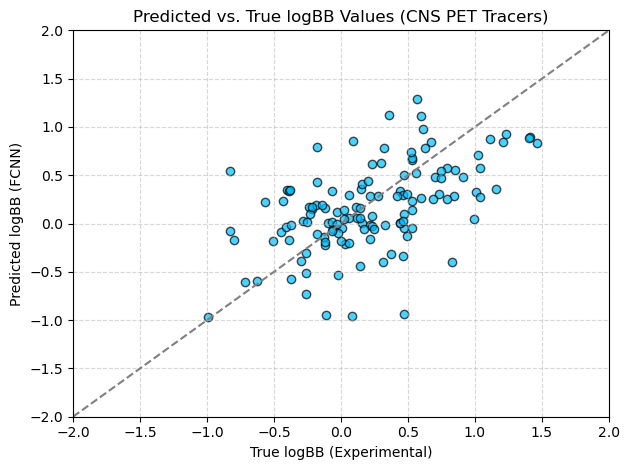

In [138]:
# scatter plot of predicted vs true logBB values
plt.figure()
plt.scatter(y_PET_logBB, y_PET_pred_logBB, alpha=0.7, color='deepskyblue', edgecolor='k')
plt.plot([-2, 2], [-2, 2], linestyle='--', color='gray') # reference line
plt.xlabel('True logBB (Experimental)')
plt.ylabel('Predicted logBB (FCNN)')
plt.title('Predicted vs. True logBB Values (CNS PET Tracers)')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Analysis of FCNN logBB Prediction**

**Analysis**

The FCNN model's performance on the CNS PET tracer dataset for logBB regression shows a clear improvement over the previously evaluated GNN model. As reflected in the scatter plot of predicted versus true logBB values, the FCNN captures the overall trend more accurately, with predictions more closely clustered around the identity line. Quantitatively, the model achieved a mean squared error (MSE) of 0.216 and a mean absolute error (MAE) of 0.367, both noticeably lower than the corresponding values for the GNN. Most significantly, the FCNN produced a positive R-squared (R²) value of 0.150, indicating that the model explains approximately 15% of the variance in the experimental logBB values. While this is still a modest level of predictive power, it stands in contrast to the negative R² observed for the GNN, highlighting the FCNN's superior generalization to this external dataset. These results suggest that descriptor-based modeling may offer a more robust approach than graph-based representations for this particular prediction task.

## **Conclusion**

Despite strong validation performance during training, both the graph neural network (GNN) and fully connected neural network (FCNN) models trained on standard CNS drug data exhibit poor generalizability when applied to the chemically distinct domain of CNS PET tracers. This lack of transferability is apparent in both the classification and regression tasks. For binary BBB classification, both models show a dramatic drop in performance when evaluated on PET tracers: the FCNN, though achieving 75% overall accuracy, fails to correctly classify the minority BBB+ class, yielding a macro F1-score of just 0.46 and an AUC of 0.36—worse than random guessing. The GNN performs only slightly better, with an AUC of 0.47 and a macro F1-score of 0.47, but still demonstrates a strong bias toward the majority class. In the regression task of predicting logBB values, both models similarly underperform. The GNN not only fails to capture any meaningful trend (R² = –0.34) but also shows large absolute and squared errors. Although the FCNN achieves a slightly better fit (R² = 0.15), the improvement is modest and still reflects weak predictive power. Taken together, these results highlight a significant limitation: models trained on standard BBB datasets may capture features relevant to typical CNS drug-like molecules, but they do not generalize well to radiolabeled PET tracers, likely due to fundamental differences in molecular structure, physicochemical properties, or data distribution. This suggests a need for domain-specific modeling or incorporation of PET tracer–relevant data during training to improve performance in this specialized subset.

## **Comparing Descriptor Distributions Between B3DB and CNS PET Tracer Compounds**

To better understand why models trained on standard CNS drug data (e.g., B3DB) fail to generalize to CNS PET tracers, we first compare the average values of molecular descriptors used by the FCNN. These descriptors include properties like molecular weight, polar surface area, and hydrogen bonding features, which influence BBB penetration. A shift in the distribution of these features between B3DB and the PET tracer dataset may help explain the observed drop in model performance.

**Comparing Mean and Standard Deviation for Each Descriptor Across the Two Datasets**

In [140]:
# map from short column names to full descriptive names
descriptor_full_names = {
    'MW': 'Molecular Weight',
    'TopoPSA': 'Topological Polar Surface Area',
    'nHBDon': 'Number of H-Bond Donors',
    'nHBAcc': 'Number of H-Bond Acceptors',
    'SLogP': 'Predicted LogP',
    'nRot': 'Number of Rotatable Bonds',
    'naRing': 'Number of Aromatic Rings'
}

In [146]:
# compute mean and std for each feature in both datasets
b3db_means = X_B3DB.mean()
b3db_stds = X_B3DB.std()
pet_means = X_PET_logBB.mean()
pet_stds = X_PET_logBB.std()

# create summary DataFrame
feature_summary_df = pd.DataFrame({
    'B3DB Mean': b3db_means,
    'B3DB Std': b3db_stds,
    'PET Mean': pet_means,
    'PET Std': pet_stds
})

# rename index to use full descriptor names
feature_summary_df.index = [descriptor_full_names[col] for col in feature_summary_df.index]

# display the updated DataFrame
print('Feature Means and Standard Deviations:\n')
print(feature_summary_df)

Feature Means and Standard Deviations:

                                 B3DB Mean    B3DB Std    PET Mean    PET Std
Molecular Weight                402.917870  181.717524  351.532928  75.384585
Topological Polar Surface Area  105.913593   78.862307   51.815736  23.345100
Number of H-Bond Donors           2.302876    2.499112    0.744186   0.763207
Number of H-Bond Acceptors        5.926692    3.984124    4.465116   1.924539
Predicted LogP                    2.164009    2.351058    3.369915   1.119064
Number of Rotatable Bonds         5.089442    3.843007    4.744186   2.440796
Number of Aromatic Rings          1.341635    1.094428    2.015504   0.901253


**Plot Mean Values with Standard Deviation Error Bars**

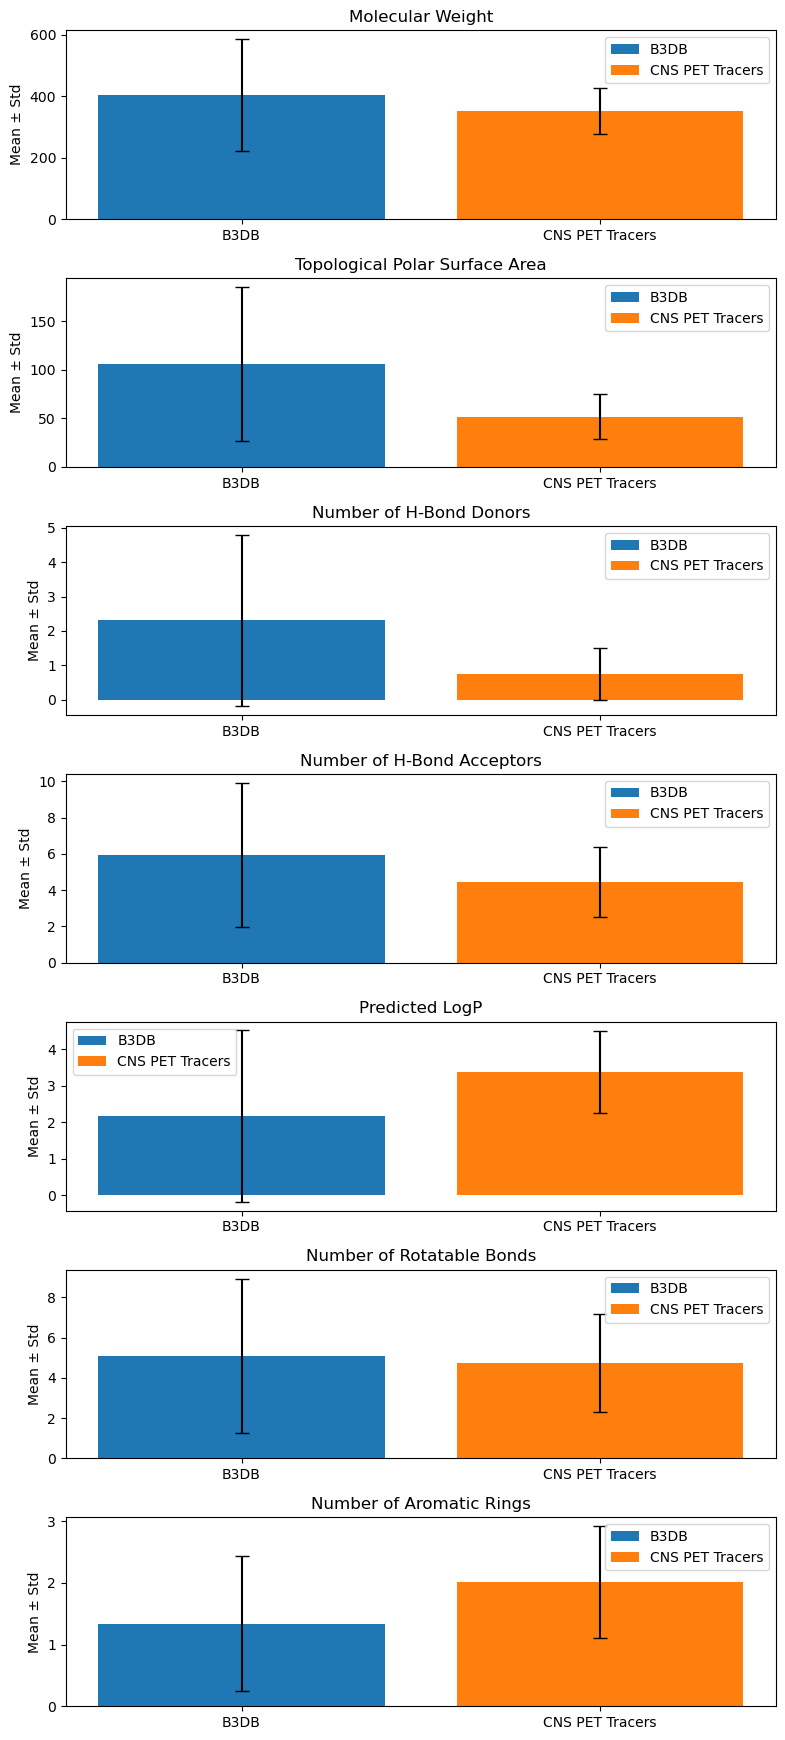

In [145]:
# define the number of descriptors
num_features = len(feature_summary_df.index)

# create subplots — one row per feature
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 2.5 * num_features), sharex=False)

# ensure axes is iterable (even if only 1 feature)
if num_features == 1:
    axes = [axes]

# loop through each descriptor to plot individually
for i, feature_name in enumerate(feature_summary_df.index):
    ax = axes[i]
    
    b3db_mean = feature_summary_df.loc[feature_name, 'B3DB Mean']
    b3db_std = feature_summary_df.loc[feature_name, 'B3DB Std']
    pet_mean = feature_summary_df.loc[feature_name, 'PET Mean']
    pet_std = feature_summary_df.loc[feature_name, 'PET Std']
    
    # plot bars with error bars
    ax.bar(['B3DB'], [b3db_mean], yerr=[b3db_std], capsize=5, label='B3DB')
    ax.bar(['CNS PET Tracers'], [pet_mean], yerr=[pet_std], capsize=5, label='CNS PET Tracers')
    
    ax.set_title(f'{feature_name}')
    ax.set_ylabel('Mean ± Std')
    ax.legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Analysis**

Most striking is the substantial divergence in topological polar surface area (TPSA) and hydrogen bonding capacity. The average TPSA for PET tracers (≈52 Å²) is less than half that of B3DB compounds (≈106 Å²), indicating that PET tracers are significantly less polar on average. Similarly, PET tracers have far fewer hydrogen bond donors (0.74 vs. 2.30) and slightly fewer acceptors, both of which are critical determinants of blood-brain barrier permeability.

In contrast, logP, a measure of lipophilicity, is significantly higher in PET tracers (mean ≈3.37) than in B3DB compounds (mean ≈2.16), reinforcing that PET tracers tend to be more hydrophobic. There is also a modest shift in molecular weight, with PET tracers being lighter on average (≈352 Da vs. 403 Da). Finally, PET tracers contain more aromatic rings on average (≈2.02 vs. 1.34), which could affect how these molecules are recognized or transported across the BBB.

Taken together, these differences suggest that PET tracers occupy a distinct chemical space from the CNS drugs represented in the B3DB dataset. The FCNNs trained on B3DB have thus likely learned feature associations that do not fully capture the characteristics of PET tracers, leading to poor extrapolation. This domain shift is a plausible and likely significant contributor to the observed lack of model generalizability observed in both classification and regression tasks.

**Apply PCA and Visualize Descriptor Space (FCNN Features)**

In [147]:
from sklearn.decomposition import PCA

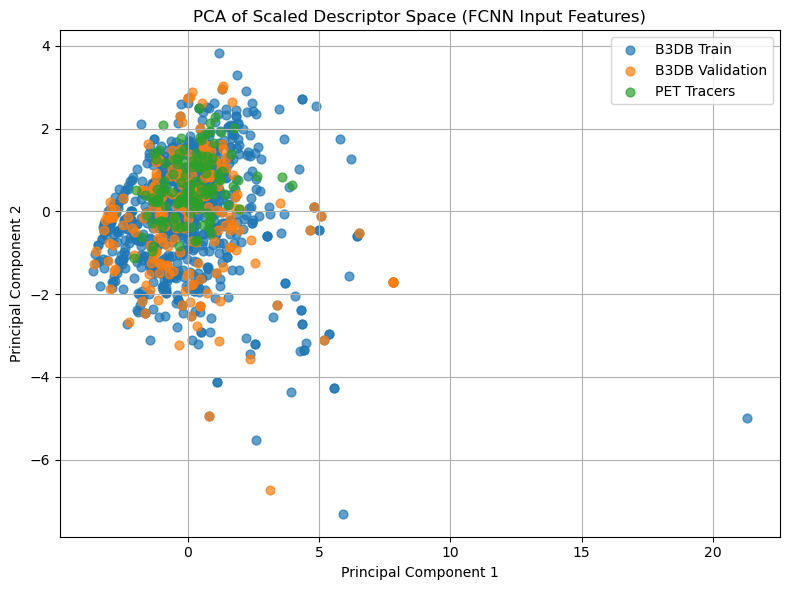

In [153]:
# concatenate all datasets and add labels
X_combined = pd.concat([
    X_train_scaled_reg.assign(Source='B3DB Train'),
    X_val_scaled_reg.assign(Source='B3DB Validation'),
    X_PET_scaled_logBB.assign(Source='PET Tracers')
])

# apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.drop(columns='Source')) # drop label column for PCA

# wrap into a dataframe for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Source'] = X_combined['Source'].values

# plot PCA
plt.figure(figsize=(8, 6))
for group in ['B3DB Train', 'B3DB Validation', 'PET Tracers']:
    subset = pca_df[pca_df['Source'] == group]
    plt.scatter(subset['PC1'], subset['PC2'], label=group, alpha=0.7, s=40)

plt.title('PCA of Scaled Descriptor Space (FCNN Input Features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis**

The PCA plot of the scaled descriptor space offers additional support for the hypothesis that differences in feature distributions may underlie the poor generalizability of models trained on B3DB data when applied to CNS PET tracers. The green points representing PET tracers largely cluster within the broader cloud of B3DB train and validation points, but they are confined to a relatively compact region—suggesting that PET tracers span a narrower range of chemical descriptor space. This is consistent with the earlier observation that PET tracers exhibit lower standard deviations across most descriptors and have shifted means for features such as topological polar surface area (TPSA), H-bond donors, and predicted LogP.

While there is overlap between the PET tracers and B3DB compounds, the denser and more centralized clustering of the PET tracers hints at possible covariate shift: the training data spans more diverse regions of the feature space than the test data, potentially leading the model to underperform on this more chemically constrained subset. This reinforces the idea that domain mismatch is a key limitation to model generalization in this context.

**Feature Comparison by BBB Class: B3DB vs. PET Tracers**

In [181]:
# separate the datasets by BBB class using label columns from each dataset
b3db_plus = X_B3DB[df_balanced['BBB+/BBB-'] == 'BBB+']      # BBB+ compounds from B3DB
b3db_minus = X_B3DB[df_balanced['BBB+/BBB-'] == 'BBB-']     # BBB− compounds from B3DB
pet_plus = X_PET_logBB[pet_df_selected['Classification'] == 'BBB+']  # BBB+ compounds from PET
pet_minus = X_PET_logBB[pet_df_selected['Classification'] == 'BBB-'] # BBB− compounds from PET

# compute summary statistics for BBB+ only
summary_plus = pd.DataFrame({
    'B3DB (BBB+) Mean': b3db_plus.mean(),
    'B3DB (BBB+) Std': b3db_plus.std(),
    'PET (BBB+) Mean': pet_plus.mean(),
    'PET (BBB+) Std': pet_plus.std()
})

# compute summary statistics for BBB− only
summary_minus = pd.DataFrame({
    'B3DB (BBB−) Mean': b3db_minus.mean(),
    'B3DB (BBB−) Std': b3db_minus.std(),
    'PET (BBB−) Mean': pet_minus.mean(),
    'PET (BBB−) Std': pet_minus.std()
})

# rename indices to full descriptor names for readability
summary_plus.index = [descriptor_full_names[col] for col in summary_plus.index]
summary_minus.index = [descriptor_full_names[col] for col in summary_minus.index]

# print summaries for BBB+ compounds
print('Feature Comparison for BBB+ Compounds:\n')
print(summary_plus)
print('\n' + '='*80 + '\n')  # separator line

# print summaries for BBB- compounds
print('Feature Comparison for BBB− Compounds:\n')
print(summary_minus)

Feature Comparison for BBB+ Compounds:

                                B3DB (BBB+) Mean  B3DB (BBB+) Std  \
Molecular Weight                      341.632855       118.411398   
Topological Polar Surface Area         64.479972        38.971748   
Number of H-Bond Donors                 1.235005         1.086205   
Number of H-Bond Acceptors              4.112592         2.258152   
Predicted LogP                          2.872474         1.569282   
Number of Rotatable Bonds               3.929849         2.817363   
Number of Aromatic Rings                1.274290         1.018686   

                                PET (BBB+) Mean  PET (BBB+) Std  
Molecular Weight                     351.762047       78.630278  
Topological Polar Surface Area        54.692936       23.495499  
Number of H-Bond Donors                0.779817        0.797656  
Number of H-Bond Acceptors             4.587156        1.982381  
Predicted LogP                         3.210725        1.079236  
Number of R

**Analysis**

The feature comparison helps explain the the FCNN’s poor classification performance on PET tracers. For BBB+ compounds, the mean values for key descriptors such as molecular weight, topological polar surface area (TPSA), and number of H-bond donors and acceptors are relatively close between the two datasets, with only minor deviations. This partial alignment may explain the FCNN’s relatively stronger performance on BBB+ PET tracers. However, for BBB− compounds, the mean feature values diverge significantly. PET tracers classified as BBB− exhibit much lower TPSA (36.1 vs. 147.3), fewer hydrogen bond donors (0.55 vs. 3.37), and notably higher predicted LogP values (4.24 vs. 1.46) compared to B3DB BBB− compounds. These differences indicate that the PET tracers occupy a very different chemical space than what the FCNN learned from in B3DB, especially in the BBB− class. As a result, the model likely struggles to recognize BBB− patterns in the PET data, having been trained on a set with substantially different physicochemical profiles. This distribution shift underscores the challenge of generalizing from CNS drug-like training data to structurally distinct PET tracers.

**PCA Visualization of FCNN Input Features by BBB Class**

In [184]:
# create new copies with reset indices to preserve original variables
X_train_scaled_B3DB_reset = X_train_scaled_B3DB.reset_index(drop=True)
X_val_scaled_B3DB_reset = X_val_scaled_B3DB.reset_index(drop=True)
y_train_B3DB_reset = y_train_B3DB.reset_index(drop=True)
y_val_B3DB_reset = y_val_B3DB.reset_index(drop=True)

# filter BBB+ and BBB− with reset index versions
X_train_plus = X_train_scaled_B3DB_reset[y_train_B3DB_reset == 'BBB+'].copy()
X_val_plus = X_val_scaled_B3DB_reset[y_val_B3DB_reset == 'BBB+'].copy()
X_PET_plus = X_PET_scaled_logBB[pet_df_selected['Classification'] == 'BBB+'].copy()

X_train_minus = X_train_scaled_B3DB_reset[y_train_B3DB_reset == 'BBB-'].copy()
X_val_minus = X_val_scaled_B3DB_reset[y_val_B3DB_reset == 'BBB-'].copy()
X_PET_minus = X_PET_scaled_logBB[pet_df_selected['Classification'] == 'BBB-'].copy()

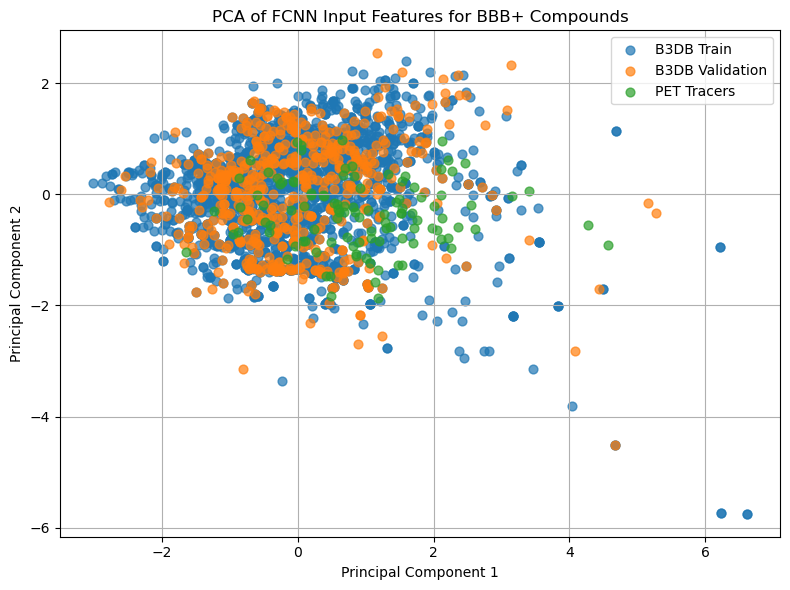

In [187]:
# concatenate BBB+ data
X_combined_plus = pd.concat([
    X_train_plus.assign(Source='B3DB Train'),
    X_val_plus.assign(Source='B3DB Validation'),
    X_PET_plus.assign(Source='PET Tracers')
])

# run PCA on BBB+ only
pca = PCA(n_components=2)
X_pca_plus = pca.fit_transform(X_combined_plus.drop(columns='Source'))

# wrap into DataFrame for plotting
pca_df_plus = pd.DataFrame(X_pca_plus, columns=['PC1', 'PC2'])
pca_df_plus['Source'] = X_combined_plus['Source'].values

# plot
plt.figure(figsize=(8, 6))
for group in ['B3DB Train', 'B3DB Validation', 'PET Tracers']:
    subset = pca_df_plus[pca_df_plus['Source'] == group]
    plt.scatter(subset['PC1'], subset['PC2'], label=group, alpha=0.7, s=40)

plt.title('PCA of FCNN Input Features for BBB+ Compounds')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

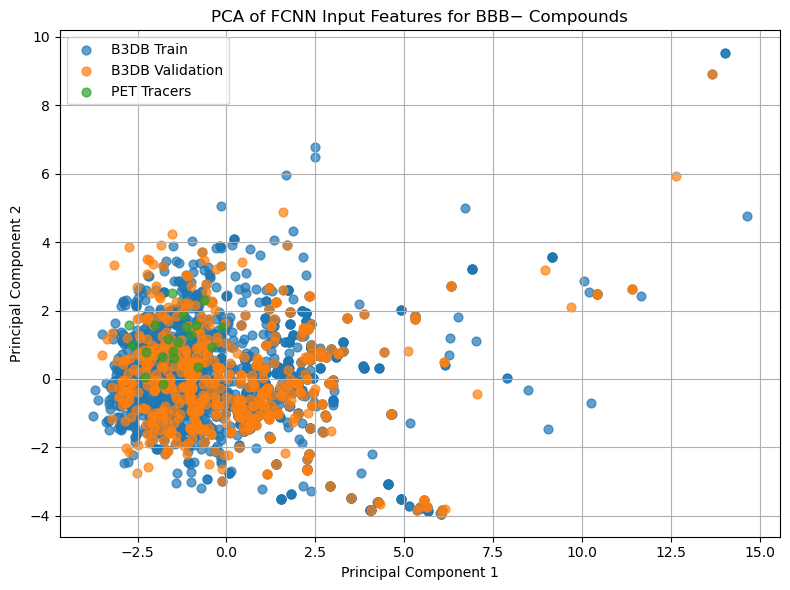

In [188]:
X_combined_minus = pd.concat([
    X_train_minus.assign(Source='B3DB Train'),
    X_val_minus.assign(Source='B3DB Validation'),
    X_PET_minus.assign(Source='PET Tracers')
])

pca = PCA(n_components=2)
X_pca_minus = pca.fit_transform(X_combined_minus.drop(columns='Source'))

pca_df_minus = pd.DataFrame(X_pca_minus, columns=['PC1', 'PC2'])
pca_df_minus['Source'] = X_combined_minus['Source'].values

plt.figure(figsize=(8, 6))
for group in ['B3DB Train', 'B3DB Validation', 'PET Tracers']:
    subset = pca_df_minus[pca_df_minus['Source'] == group]
    plt.scatter(subset['PC1'], subset['PC2'], label=group, alpha=0.7, s=40)

plt.title('PCA of FCNN Input Features for BBB− Compounds')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis**

The PCA plots of the FCNN input descriptor space for BBB+ and BBB− compounds provide valuable insight into the observed classification disparities, particularly the model’s difficulty in correctly identifying BBB− PET tracers. In the BBB+ plot, there is substantial overlap between the PET tracers (green) and the B3DB training and validation compounds (blue and orange), indicating that the descriptor profiles of BBB+ PET tracers fall largely within the distribution learned by the model. This likely contributed to the relatively stronger classification performance on BBB+ compounds. In contrast, the BBB− plot reveals a starkly different scenario: the PET tracers occupy a tighter cluster around PCA1 = 2 and PCA2 = 2, with noticeably less overlap with the broader spread of B3DB compounds. This divergence suggests that the FCNN encountered PET tracers with descriptor combinations that were underrepresented in the BBB− training distribution. As a result, this underrepresentation likely contributed to the model's heavy misclassification bias toward BBB+.

## **Comparing Structural Features Between B3DB and CNS PET Tracer Compounds**

**Visualize Representative Molecular Structures from Each Set Side by Side**

In [161]:
from rdkit.Chem import Draw # import necessary module from RDKit for visualization
from IPython.display import display   # # import display function from IPython for proper rendering (used to display images in notebooks)

In [174]:
# set the number of molecules to visualize from each group
n = 10                                                                      # number of BBB+ and BBB− molecules per source to visualize

# extract n BBB+ molecules from B3DB dataset
bbb_plus_b3db_smiles = df_balanced[df_balanced['BBB+/BBB-'] == 'BBB+']['SMILES'].dropna().sample(n=n, random_state=2025)  # randomly sample BBB+ SMILES from B3DB

# extract n BBB− molecules from B3DB dataset
bbb_minus_b3db_smiles = df_balanced[df_balanced['BBB+/BBB-'] == 'BBB-']['SMILES'].dropna().sample(n=n, random_state=2025) # randomly sample BBB− SMILES from B3DB

# extract n BBB+ molecules from PET tracer dataset
bbb_plus_pet_smiles = pet_df_selected[pet_df_selected['Classification'] == 'BBB+']['SMILES'].dropna().sample(n=n, random_state=2025) # sample BBB+ SMILES from PET

# extract n BBB− molecules from PET tracer dataset
bbb_minus_pet_smiles = pet_df_selected[pet_df_selected['Classification'] == 'BBB-']['SMILES'].dropna().sample(n=n, random_state=2025) # sample BBB− SMILES from PET

# define a helper function to convert a list of SMILES strings to RDKit Mol objects
def convert_smiles_to_mols(smiles_list):                                    # define conversion function
    return [Chem.MolFromSmiles(smi) for smi in smiles_list if Chem.MolFromSmiles(smi) is not None]  # skip invalid SMILES

# convert BBB+ and BBB− SMILES from both datasets to Mol objects
mols_bbb_plus_b3db = convert_smiles_to_mols(bbb_plus_b3db_smiles)           # convert B3DB BBB+ to molecules
mols_bbb_plus_pet = convert_smiles_to_mols(bbb_plus_pet_smiles)             # convert PET BBB+ to molecules
mols_bbb_minus_b3db = convert_smiles_to_mols(bbb_minus_b3db_smiles)         # convert B3DB BBB− to molecules
mols_bbb_minus_pet = convert_smiles_to_mols(bbb_minus_pet_smiles)           # convert PET BBB− to molecules

# combine BBB+ molecules from both datasets into a single grid for side-by-side visualization
img_bbb_plus = Draw.MolsToGridImage(                                        # generate image grid for BBB+
    mols_bbb_plus_b3db + mols_bbb_plus_pet,                                 # combine B3DB and PET molecules
    molsPerRow=n,                                                           # show all molecules in one row
    subImgSize=(160, 160),                                                  # set individual image size
    legends=[f'B3DB {i+1}' for i in range(n)] + [f'PET {i+1}' for i in range(n)]  # label each molecule
)

# combine BBB− molecules from both datasets into a separate grid
img_bbb_minus = Draw.MolsToGridImage(                                       # generate image grid for BBB−
    mols_bbb_minus_b3db + mols_bbb_minus_pet,                               # combine B3DB and PET molecules
    molsPerRow=n,                                                           # show all molecules in one row
    subImgSize=(160, 160),                                                  # set individual image size
    legends=[f'B3DB {i+1}' for i in range(n)] + [f'PET {i+1}' for i in range(n)]  # label each molecule
)

**Note:** In the visualizations below, double click on them to make them larger. 

In [176]:
# set a larger size for each molecule image
mol_img_size = (300, 300)  # width x height in pixels

BBB+ Molecules from B3DB (left) and PET Tracers (right)


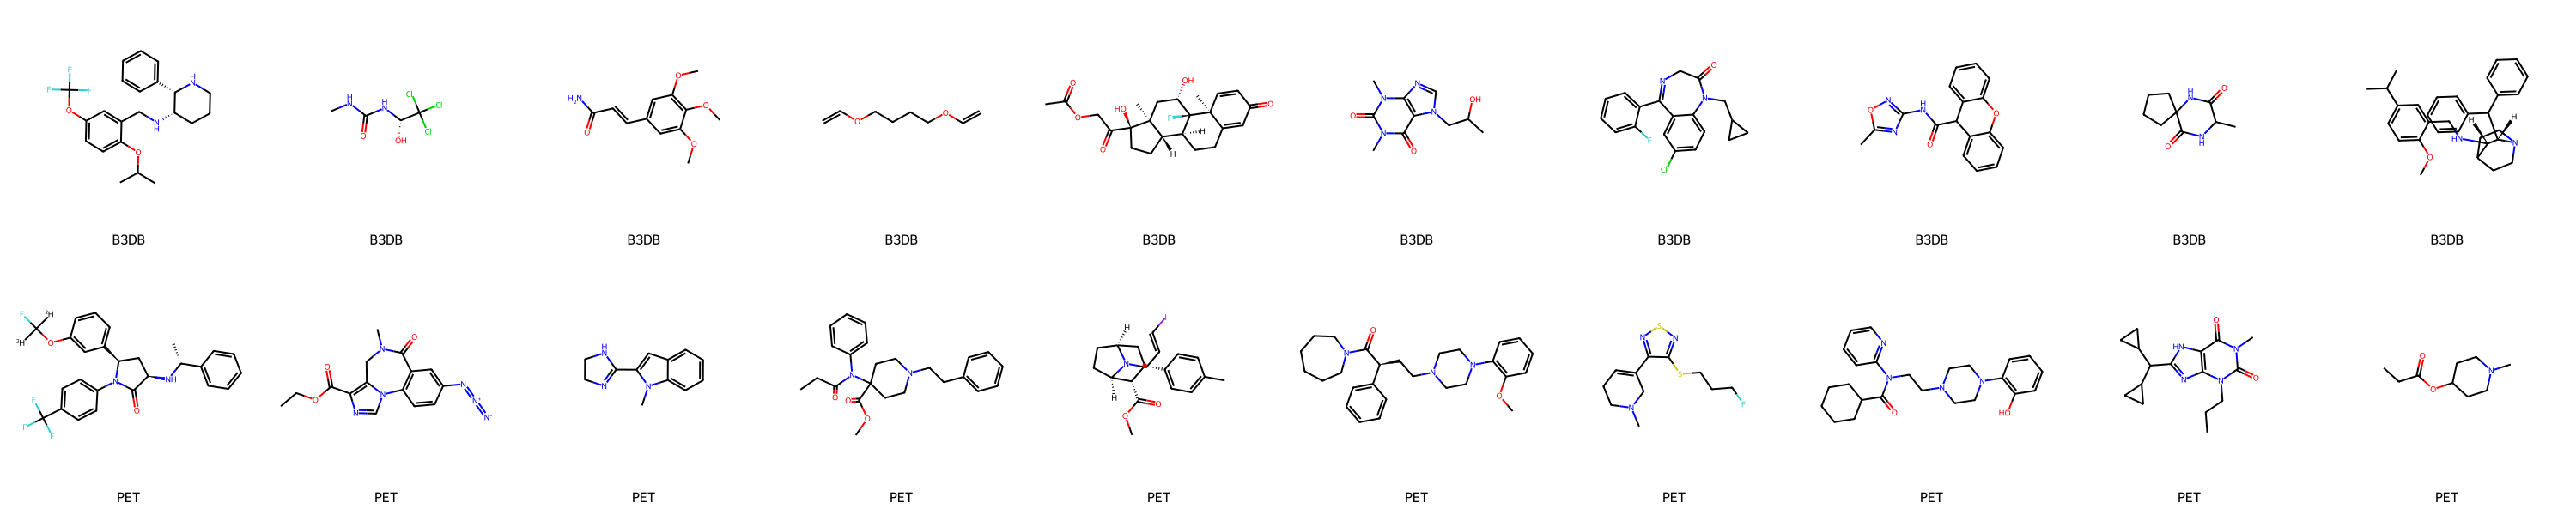

In [177]:
# create larger BBB+ image grid
img_bbb_plus = Draw.MolsToGridImage(
    mols_bbb_plus_b3db + mols_bbb_plus_pet,                # list of molecules
    molsPerRow=10,                                         # 10 molecules per row
    subImgSize=mol_img_size,                               # increase image size
    legends=['B3DB']*10 + ['PET']*10                       # add consistent labels
)

# display the larger BBB+ image
print('BBB+ Molecules from B3DB (left) and PET Tracers (right)')
display(img_bbb_plus)

BBB− Molecules from B3DB (left) and PET Tracers (right)


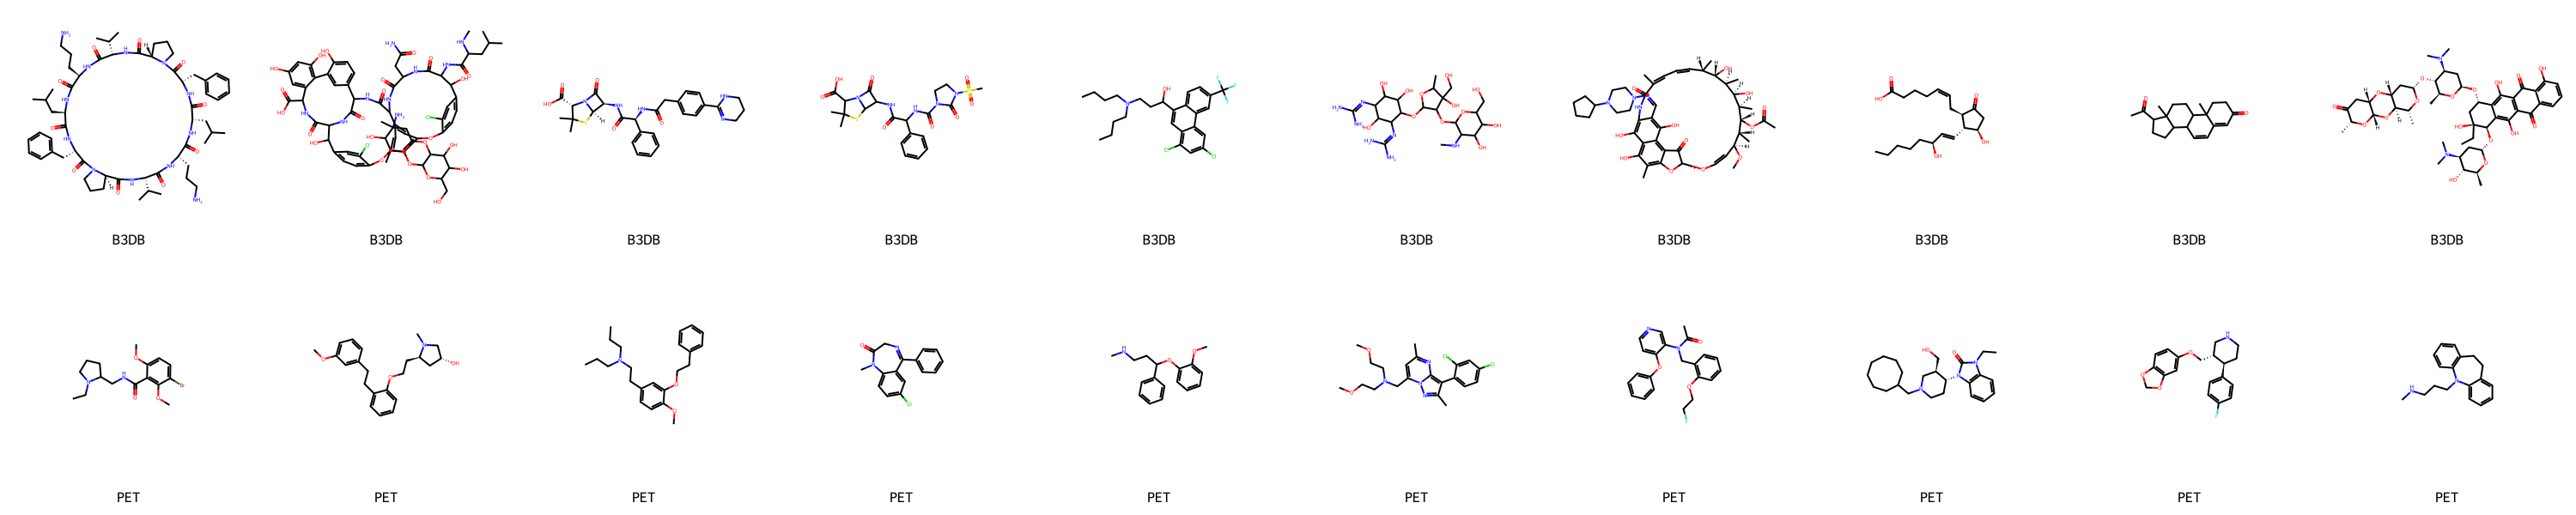

In [178]:
# create larger BBB− image grid
img_bbb_minus = Draw.MolsToGridImage(
    mols_bbb_minus_b3db + mols_bbb_minus_pet,
    molsPerRow=10,
    subImgSize=mol_img_size,
    legends=['B3DB']*10 + ['PET']*10
)

# display the larger BBB− image
print('BBB− Molecules from B3DB (left) and PET Tracers (right)')
display(img_bbb_minus)

**Analysis**

Visual inspection of representative molecules offers further insight into the GNN’s limited performance on CNS PET tracers in both classification and regression tasks. Among BBB+ compounds, there is a clear structural similarity between those in the B3DB training set and the PET tracers: both consist of relatively small, drug-like molecules with shared features such as the number of aromatic rings, number of double bonds, types of functional groups, etc. This similarity likely enabled the GNN to learn meaningful representations that supported accurate predictions for BBB+ compounds in the PET set. In contrast, the BBB− comparison reveals a pronounced structural mismatch. The B3DB BBB− molecules often include complex, bulky scaffolds such as macrocycles. Such large, complex structures are absent from the PET tracer set. These training compounds are significantly larger and more conformationally constrained than the simpler, more flexible BBB− PET tracers. Because the GNN learned to associate BBB− status with these highly specific, complex structures, it likely failed to recognize the chemically distinct PET BBB− compounds. As a result, this structural mismatch not only impaired classification performance but also compromised the regression model's ability to predict logBB, since it relied on the same learned representations.

**Compute Tanimoto Similarity Between PET Tracers and B3DB Molecules**

In [191]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

In [192]:
# initialize the Morgan fingerprint generator
morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

# compute Morgan fingerprints using new generator
def get_fp_modern(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return morgan_gen.GetFingerprint(mol)

# get SMILES
b3db_smi = df_balanced['SMILES'].dropna()
pet_smi = pet_df_selected['SMILES'].dropna()

# compute fingerprints
fps_b3db = [get_fp_modern(smi) for smi in b3db_smi if get_fp_modern(smi) is not None]
fps_pet = [get_fp_modern(smi) for smi in pet_smi if get_fp_modern(smi) is not None]

# compute Tanimoto similarities
similarities = []
for fp_pet in fps_pet:
    sims = DataStructs.BulkTanimotoSimilarity(fp_pet, fps_b3db)
    similarities.append(max(sims))  # or np.mean(sims)

# report average similarity
print('Average max Tanimoto similarity of PET tracers to B3DB compounds:', np.mean(similarities))

[20:34:06] Explicit valence for atom # 10 C, 4, is greater than permitted
[20:34:06] Explicit valence for atom # 10 C, 4, is greater than permitted


Average max Tanimoto similarity of PET tracers to B3DB compounds: 0.4893153020820199


**Analysis**

Tanimoto similarity is a metric used to compare molecular fingerprints, quantifying the structural similarity between two molecules on a scale from 0 to 1. A value of 1 indicates identical fingerprints (i.e., highly similar structures), while a value close to 0 reflects minimal overlap. In cheminformatics, a Tanimoto similarity above 0.7 is generally considered indicative of strong structural resemblance. Therefore, the observed average maximum similarity of 0.49 between CNS PET tracers and B3DB compounds suggests limited chemical overlap between the two datasets. This structural dissimilarity likely contributed to the poor generalization observed in the two GNN models (and also the two FCNN models), as molecules in the PET set fall outside the learned chemical space. Consequently, the models were unable to reliably extrapolate to novel chemotypes, particularly in tasks requiring nuanced understanding of molecular features like BBB classification and logBB regression.

**UMAP/t-SNE on Final GNN Embeddings of B3DB vs. PET Tracers**

In [195]:
import umap
from sklearn.manifold import TSNE

/Users/andrewlevy/anaconda3/envs/QBIO465_final_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[20:45:20] Explicit valence for atom # 10 C, 4, is greater than permitted
[20:45:21] Explicit valence for atom # 10 C, 4, is greater than permitted
/Users/andrewlevy/anaconda3/envs/QBIO465_final_project/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/andrewlevy/anaconda3/envs/QBIO465_final_project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/andrewlevy/anaconda3/envs/QBIO465_final_project/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random init

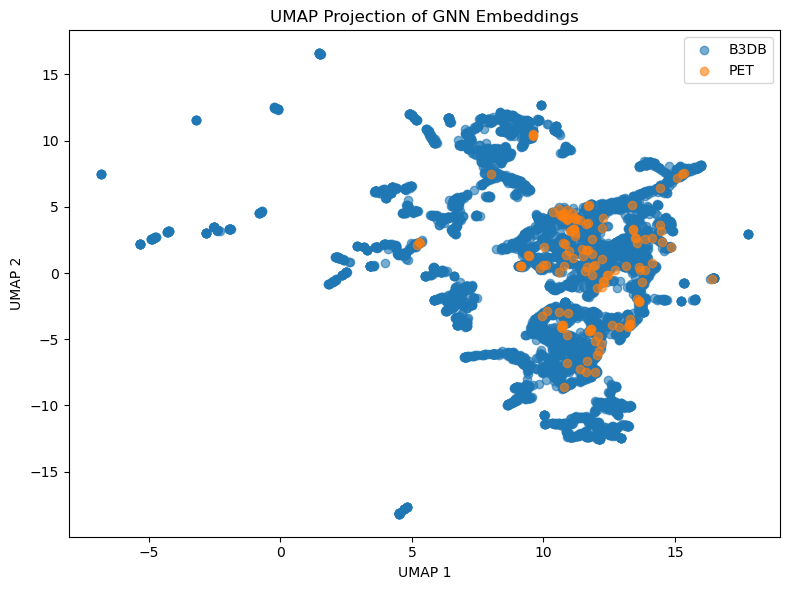

In [197]:
# define function to extract final GNN-pooled embedding from SMILES
def get_gnn_embedding(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    try:
        # featurize molecule as graph
        data = mol_to_pyg_data_B3DB(mol, label=0)
        if data.edge_index.numel() == 0:  # skip molecules with no bonds
            return None

        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data = data.to(device_GNN_B3DB)

        # pass through GNN to get pooled vector
        with torch.no_grad():
            x = model_GNN_B3DB.conv1(data.x, data.edge_index, data.edge_attr)
            x = F.relu(x)
            x = model_GNN_B3DB.conv2(x, data.edge_index, data.edge_attr)
            x = F.relu(x)
            pooled = global_mean_pool(x, data.batch)

        return pooled.cpu().numpy().flatten()
    
    except Exception as e:
        print(f'Error processing SMILES: {smiles}\n{e}')
        return None

# collect GNN embeddings for each valid molecule in each set
b3db_embeddings = [get_gnn_embedding(smi) for smi in b3db_smi if get_gnn_embedding(smi) is not None]
pet_embeddings = [get_gnn_embedding(smi) for smi in pet_smi if get_gnn_embedding(smi) is not None]

# combine embeddings and generate labels
X_all = np.vstack(b3db_embeddings + pet_embeddings)  # combine all embeddings
labels = ['B3DB'] * len(b3db_embeddings) + ['PET'] * len(pet_embeddings)  # track origin

# reduce dimensionality using UMAP for visualization
reducer = umap.UMAP(random_state=42)
X_embedded = reducer.fit_transform(X_all)

# plot the embedded 2D projection
plt.figure(figsize=(8, 6))
for label in ['B3DB', 'PET']:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], label=label, alpha=0.6)

plt.title('UMAP Projection of GNN Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.tight_layout()
plt.show()

**Analysis**

The UMAP projection of GNN embeddings shows that PET tracers are largely embedded within the same regions occupied by B3DB compounds. This suggests that the GNN learned a representation space where PET tracers are not outliers, but instead fall well within the distribution of training data. As a result, this visualization does not explain the model’s poor generalization performance on PET tracers. Despite the apparent embedding overlap, the GNN still struggled to classify and regress PET tracer properties accurately, implying that the failure likely stems from subtler factors (as opposed to  global differences in chemical space coverage). 

**Identify Misclassified PET Tracers and Visualize Their Structures**

In [203]:
# get labels with consistent indexing
true_labels = y_PET_true.reset_index(drop=True)
pred_labels = y_PET_pred_labels_GNN.reset_index(drop=True)

# define masks for misclassification types
false_neg_mask = (true_labels == 'BBB+') & (pred_labels == 'BBB-')  # predicted BBB- but actually BBB+
false_pos_mask = (true_labels == 'BBB-') & (pred_labels == 'BBB+')  # predicted BBB+ but actually BBB-

# extract relevant data
false_neg_df = pet_df_selected[false_neg_mask].copy()
false_pos_df = pet_df_selected[false_pos_mask].copy()

# convert SMILES to RDKit Mol objects
false_neg_mols = [Chem.MolFromSmiles(smi) for smi in false_neg_df['SMILES'] if Chem.MolFromSmiles(smi) is not None]
false_pos_mols = [Chem.MolFromSmiles(smi) for smi in false_pos_df['SMILES'] if Chem.MolFromSmiles(smi) is not None]

# create simple index-based legends
false_neg_legend = [f'{i+1}' for i in range(len(false_neg_mols[:10]))]
false_pos_legend = [f'{i+1}' for i in range(len(false_pos_mols[:10]))]

False Negatives (True: BBB+, Predicted: BBB-):


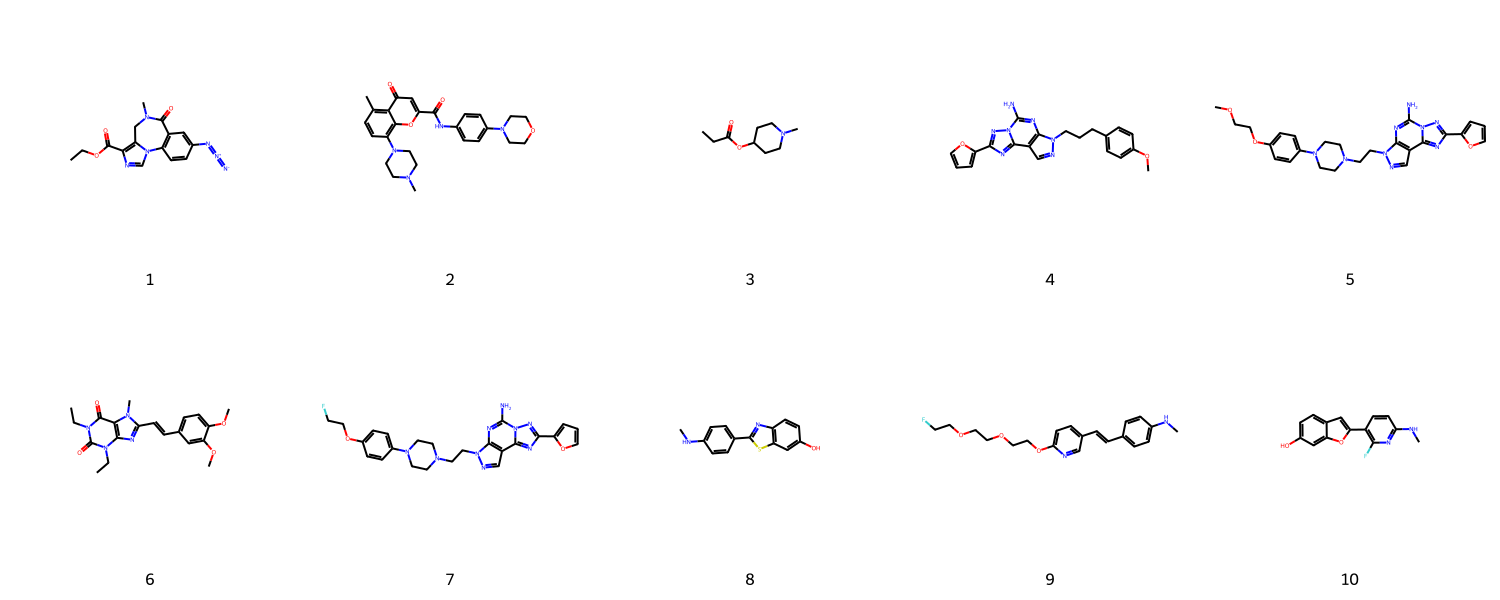

In [204]:
# plot grid of false negatives
img_false_neg = Draw.MolsToGridImage(
    false_neg_mols[:10],
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=false_neg_legend
)
print('False Negatives (True: BBB+, Predicted: BBB-):')
display(img_false_neg)

False Positives (True: BBB-, Predicted: BBB+):


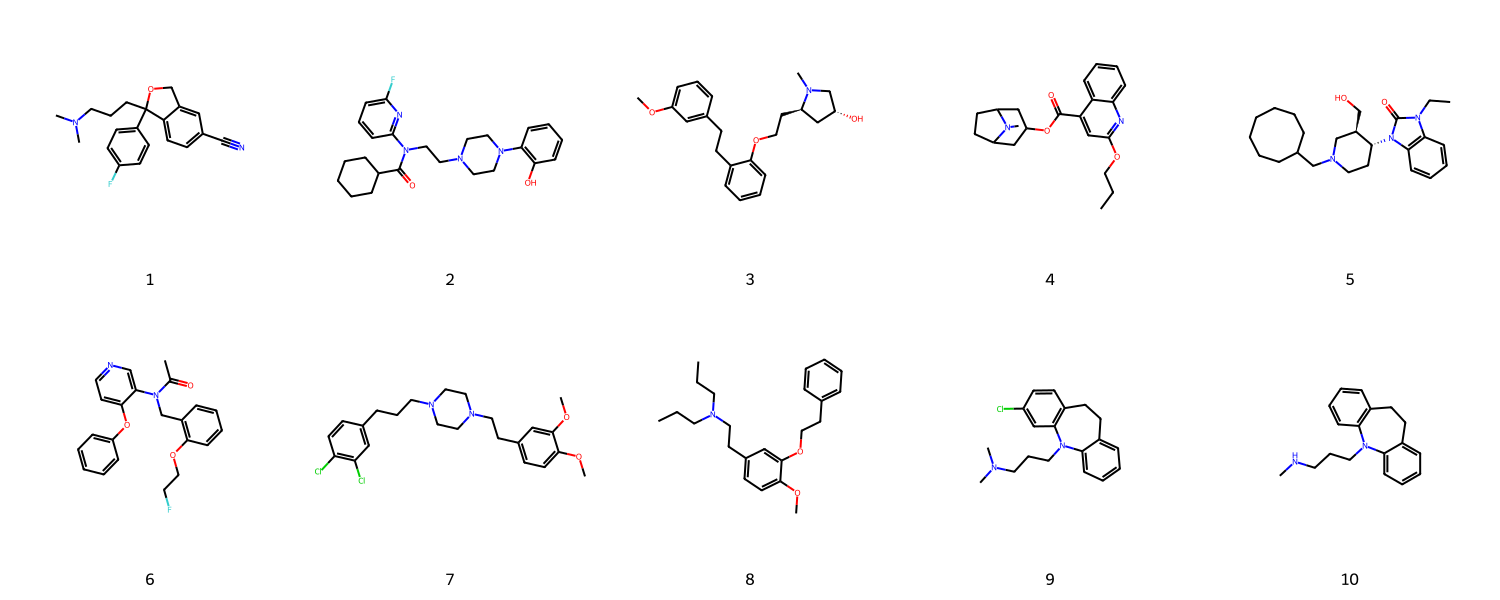

In [205]:
# plot grid of false positives
img_false_pos = Draw.MolsToGridImage(
    false_pos_mols[:10],
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=false_pos_legend
)
print('False Positives (True: BBB-, Predicted: BBB+):')
display(img_false_pos)

In [206]:
# get SMILES for the first 10 false negatives (true BBB+, predicted BBB-)
false_neg_smiles = false_neg_df['SMILES'].dropna().tolist()[:10]

# get SMILES for the first 10 false positives (true BBB-, predicted BBB+)
false_pos_smiles = false_pos_df['SMILES'].dropna().tolist()[:10]

# print out the SMILES in an organized format
print('False Negatives (True: BBB+, Predicted: BBB-):')
for i, smi in enumerate(false_neg_smiles, 1):
    print(f'{i}: {smi}')

print('\nFalse Positives (True: BBB-, Predicted: BBB+):')
for i, smi in enumerate(false_pos_smiles, 1):
    print(f'{i}: {smi}')

False Negatives (True: BBB+, Predicted: BBB-):
1: O=C(N(C)CC1=C(C(OCC)=O)N=CN12)C3=C2C=CC(N=[N+]=[N-])=C3
2: CN1CCN(C2=C(OC(C(NC3=CC=C(N4CCOCC4)C=C3)=O)=CC5=O)C5=C(C)C=C2)CC1
3: O=C(CC)OC1CCN(C)CC1
4: COC1=CC=C(C=C1)CCCN2C(N=C(N3C4=NC(C5=CC=CO5)=N3)N)=C4C=N2
5: NC1=NC2=C(C=NN2CCN3CCN(CC3)C4=CC=C(C=C4)OCCOC)C5=NC(C6=CC=CO6)=NN15
6: COC1=CC(/C=C/C2=NC(N(CC)C(N(CC)C3=O)=O)=C3N2C)=CC=C1OC
7: NC1=NC2=C(C=NN2CCN3CCN(CC3)C4=CC=C(C=C4)OCCF)C5=NC(C6=CC=CO6)=NN15
8: OC1=CC2=C(N=C(C3=CC=C(NC)C=C3)S2)C=C1
9: FCCOCCOCCOC1=CC=C(/C=C/C2=CC=C(NC)C=C2)C=N1
10: OC1=CC=C2C(OC(C3=C(F)N=C(NC)C=C3)=C2)=C1

False Positives (True: BBB-, Predicted: BBB+):
1: FC(C=C1)=CC=C1C2(CCCN(C)C)C3=CC=C(C#N)C=C3CO2
2: OC1=C(N2CCN(CCN(C3=NC(F)=CC=C3)C(C4CCCCC4)=O)CC2)C=CC=C1
3: COC1=CC=CC(CCC2=CC=CC=C2OCC[C@H]3N(C)C[C@H](O)C3)=C1
4: CCCOC1=NC2=CC=CC=C2C(C(OC3CC(CC4)N(C)C4C3)=O)=C1
5: O=C1N([C@H]2[C@H](CO)CN(CC3CCCCCCC3)CC2)C(C=CC=C4)=C4N1CC
6: CC(N(CC1=C(OCCF)C=CC=C1)C(C=NC=C2)=C2OC3=CC=CC=C3)=O
7: ClC1=C(Cl)C=CC(CCCN2CCN(

**Analysis**

Among the false negatives (true BBB+ compounds classified as BBB−), many molecules contain recognizable drug-like substructures such as substituted aromatic rings, flexible linkers, and small polar groups (e.g., -OH, -F, amides). These structures resemble typical CNS-active compounds, which should be classified as BBB+. However, several also contain features like nitro groups or extended conjugated systems, which may have been underrepresented in the training data for BBB+ and more commonly associated with BBB− labels. This structural ambiguity may have led the GNN to misinterpret them.

In contrast, the false positives (true BBB− compounds predicted as BBB+) often feature highly lipophilic scaffolds, including long alkyl chains, fluorinated aromatics, and bulky heterocycles. These hydrophobic features may resemble patterns frequently associated with BBB+ status in the B3DB training set. However, despite these similarities, the actual biological barrier penetrability of such compounds may be low due pharmacokinetic factors (like like poor aqueous solubility, limited passive diffusion, or metabolic instability) and efflux transporter activity (biological mechanisms where specialized proteins, such as P-glycoprotein actively pump foreign substances out of the brain). Obviously, none of those features are captured by the GNN (which relies on structural and atomic-levle characteristics), and as a result, this likely contributed to the misclassification.

Overall, while these compound structures do not provide definitive mechanistic reasons for misclassification, their features suggest that certain chemical motifs may lead to confusion if not adequately balanced in the training data. Additionally, this highlights the limitations of relying solely on structural features without incorporating broader biological context; thus, it underscores the importance of integrating complementary information (for example, pharmacokinetic data, transporter affinity, or in vivo permeability data) to enhance model generalizability.